<a href="https://colab.research.google.com/github/Nmg1994/Beehive-mortality-assessment/blob/main/Beehive_Mortality_Assessment_RSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary modules

In [ ]:
!pip install scikit-survival pdpbox matplotlib
!pip install tqdm
!pip install lifelines
!pip install rpart
!pip install randomSurvivalForest
!pip install rasterio

# Importing necessary libraries

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import math
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import (
    concordance_index_censored,
    cumulative_dynamic_auc,
    integrated_brier_score
)

from sksurv.util import Surv
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import KBinsDiscretizer
import rasterio
import glob
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

# Mounting Google Drive

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Preprocessing Beehive data before undergoing further preprocessing in ArcGIS Pro

In [ ]:
import warnings

# Ignoring warning messages
warnings.filterwarnings("ignore")

In [ ]:
# Defining a custom date parsing function
def parse_datetime(dt):
  return pd.to_datetime(dt.split(' ', 1)[0])  # Splitting the string at the first space character

# Reading the dataframe with the custom parsing function
California_df = pd.read_csv("/content/drive/My Drive/Beehive_mortality/California_samples.csv", parse_dates=['report_submitted_at'], date_parser=parse_datetime)
Quebec_df = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Quebec_samples.csv", parse_dates=['report_submitted_at'], date_parser=parse_datetime)

# Exporting dataframes to the Google Drive, avoiding to repeat doing the same preprocessing later
California_df.to_csv("/content/drive/My Drive/Beehive_mortality/California_samples_date_format_modified.csv", index=False)
Quebec_df.to_csv("/content/drive/My Drive/Beehive_mortality/Quebec_samples_date_format_modified.csv", index=False)

In [ ]:
# Reading exported datasets
California = pd.read_csv("/content/drive/My Drive/Beehive_mortality/California_samples_date_format_modified.csv")
Quebec = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Quebec_samples_date_format_modified.csv")

In [ ]:
# Further preprocessing of beehive data defining a function

def preprocessing_dataframe(DF):
  DF = DF.drop(['OBJECTID *','Shape *','tag_serial_number', 'fob', 'fobr', 'varroa', 'yard_name', 'report_notes', 'report_report_type', 'operation_id', 'queen_variant', 'queen_status', 'state_province_long', 'country_long', 'city', 'yard_type', 'crop_type'], axis=1)

  # Replace "<Null>" values with np.nan
  DF.replace('<Null>', np.nan, inplace=True)

  # Droping the rows containing NaN in any column
  DF.dropna(inplace=True)

  Data_frame = DF.sort_values(by = 'report_submitted_at', axis = 0, ascending=True).reset_index(drop = True)

  # Converting the datetime column to datetime format
  Data_frame['report_submitted_at'] = pd.to_datetime(Data_frame['report_submitted_at'])

  # Extracting the year and month into separate columns
  Data_frame['year'] = Data_frame['report_submitted_at'].dt.year
  Data_frame['month'] = Data_frame['report_submitted_at'].dt.month

  # Adding month-year column
  Data_frame['YearMonth'] = pd.to_datetime(Data_frame.report_submitted_at).apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))

  # Subseting deadouts only
  dfdo = Data_frame[(Data_frame.action_detail == 'deadout')]
  # Counting number of rows per month per operation
  deadouts_month = dfdo.groupby(['YearMonth'])['report_submitted_at'].size().sort_index().reset_index()

  #Sorting dates
  deadouts_month['YearMonth'] = pd.to_datetime(deadouts_month['YearMonth']).dt.strftime("%Y-%m")
  deadouts_month = deadouts_month.set_index('YearMonth').sort_index().reset_index()
  print(deadouts_month)
  # Annual deadouts

  for y in Data_frame['year'].unique():
    print('Number of dead hives in the year ' f'{y}' ' is: ', Data_frame[(Data_frame['year'] == y) & (Data_frame['action_detail'] == 'deadout')].shape[0])

  # Total hives annually
  for y in Data_frame['year'].unique():
    print('Number of total hives in the year ' f'{y}' ' is: ', Data_frame[Data_frame['year'] == y]['hive_identity_id'].drop_duplicates().shape[0]) # or using .unique().shape[0] instead of .drop_duplicates().shape[0]

  # plotting
  ax = sns.barplot(data=deadouts_month, y="report_submitted_at", x= 'YearMonth')
  ax.set(xlabel='Date', ylabel='Number of scanned deadouts', title = "Dead hive scans per month")
  plt.xticks(rotation=45, ha='right')
  plt.show()
  Data_frame.drop(columns=['report_submitted_at','YearMonth'], inplace=True)
  return Data_frame


In [ ]:
# Applying the preprocessing_dataframe function to both California and Quebec beehive datasets
California_preprocessed_df = preprocessing_dataframe(California)
Quebec_preprocessed_df = preprocessing_dataframe(Quebec)

In [ ]:
# Exporting beehive datasets in the year 2023 to be further processed in ArcGIS Pro
California_preprocessed_df[California_preprocessed_df['year'] == 2023].to_csv("/content/drive/My Drive/Beehive_mortality/California_samples_2023.csv", index=False)
Quebec_preprocessed_df[Quebec_preprocessed_df['year'] == 2023].to_csv("/content/drive/My Drive/Beehive_mortality/Quebec_samples_2023.csv", index=False)

# Data preprocessing after gathering data and preprocessing them in ArcGIS Pro

In [ ]:
# Reading exported datasets
California = pd.read_csv("/content/drive/My Drive/Beehive_mortality/California_data.csv")
Quebec = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Quebec_data.csv")
California_df = California.drop(columns =['year']).reset_index(drop = True) # since only the year 2023 was chosen
Quebec_df = Quebec.drop(columns =['year']).reset_index(drop = True)

<ipython-input-30-47079bf0369c>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  California = pd.read_csv("/content/drive/My Drive/Beehive_mortality/California_data.csv")
<ipython-input-30-47079bf0369c>:3: DtypeWarning: Columns (63,65,71,76) have mixed types. Specify dtype option on import or set low_memory=False.
  Quebec = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Quebec_data.csv")


In [ ]:
# Choosing ideal beekeeping seasons for each study area
California_df = California_df[California_df['month'] > 4]
Quebec_df = Quebec_df[(Quebec_df['month'] > 3) & (Quebec_df['month'] < 11)]

# Dropping the corresponding values of excluded months from the initial data
# California
Calif_all_columns_drop =[]
Calif_column_Jan = California_df.filter(regex='Jan').columns
Calif_column_Feb = California_df.filter(regex='Feb').columns
Calif_column_Mar = California_df.filter(regex='Mar').columns
Calif_column_Apr = California_df.filter(regex='Apr').columns
Calif_all_columns_drop.extend(Calif_column_Jan)
Calif_all_columns_drop.extend(Calif_column_Feb)
Calif_all_columns_drop.extend(Calif_column_Mar)
Calif_all_columns_drop.extend(Calif_column_Apr)

California_df = California_df.drop(columns =Calif_all_columns_drop).reset_index(drop = True)

# Quebec
Quebec_all_columns_drop = []
Quebec_column_Jan = Quebec_df.filter(regex='Jan').columns
Quebec_column_Feb = Quebec_df.filter(regex='Feb').columns
Quebec_column_Mar = Quebec_df.filter(regex='Mar').columns
Quebec_column_Nov = Quebec_df.filter(regex='Nov').columns
Quebec_column_Dec = Quebec_df.filter(regex='Dec').columns

Quebec_all_columns_drop.extend(Quebec_column_Jan)
Quebec_all_columns_drop.extend(Quebec_column_Feb)
Quebec_all_columns_drop.extend(Quebec_column_Mar)
Quebec_all_columns_drop.extend(Quebec_column_Nov)
Quebec_all_columns_drop.extend(Quebec_column_Dec)

Quebec_df = Quebec_df.drop(columns =Quebec_all_columns_drop).reset_index(drop = True)

# Hive id
Calif_Hive_ID = California_df['hive_identity_id'].drop_duplicates().to_numpy()
Quebec_Hive_ID = Quebec_df['hive_identity_id'].drop_duplicates().to_numpy()

In [ ]:
California_df['LandC_Variety_Calif'].replace("<Null>", 1, inplace=True) # there must be at least one crop in which the beehive is placed
Quebec_df['LandC_Variety_Qc'].replace("<Null>", 1, inplace=True) # there must be at least one crop in which the beehive is placed

California_df.replace("<Null>", np.nan, inplace=True)
Quebec_df.replace("<Null>", np.nan, inplace=True)

In [ ]:
def calculating_missing_NDVI(row, col_name, col_index, sorted_NDVI_columns):
  # Estimating missing NDVI values
  if pd.isna(row[col_name]):

    if col_index == 0:
      return row[sorted_NDVI_columns[col_index + 1]]

    elif col_index == len(sorted_NDVI_columns) - 1:
      return row[sorted_NDVI_columns[col_index - 1]]

    else:
      previous_month = sorted_NDVI_columns[col_index - 1]
      next_month = sorted_NDVI_columns[col_index + 1]
      return (row[previous_month] + row[next_month]) / 2
  else:
      return row[col_name]

def calculating_missing_NDVI_all_columns(dataframe):
  NDVI_columns = [col for col in dataframe.columns if 'NDVI' in col]
  months_order = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

  # Sorting NDVI_columns based on months
  sorted_NDVI_columns = sorted(NDVI_columns, key=lambda x: months_order[x.split('_')[2]])

  for col_index, col_name in enumerate(sorted_NDVI_columns): # Enumerate to get both index and name
    # Applying the calculating_missing_NDVI function to replace NaN values in each column if there is
    dataframe[col_name] = dataframe.apply(calculating_missing_NDVI, axis=1, args=(col_name, col_index, sorted_NDVI_columns))

  return dataframe

# Regardless of calculating monthly NDVI values using all the Landsat 8 satellite imagery in GEE, there were some missing values needed calculating
# Applying calculating_missing_NDVI_all_columns function to estimate missing NDVI values in Quebec
Quebec_df = calculating_missing_NDVI_all_columns(Quebec_df)

In [ ]:
# Defining the function to create the main dataframes for feeding into the RSF model
def preprocessing_data(Data_frame, hives_ID):

  months_title = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
  first_part_columns = ['Event','hive_identity_id','hive_age', 'Longitude', 'Latitude', 'Months']

  # Habitat quality
  Habitat_quality = ['Crop diversity', 'Distance from roads', 'Distance from water', 'DEM', 'Slope']
  # Temporally dynamic criteria including one habitat quality variable (i.e., NDVI) and four meteorological variables; monthly basis
  Temporal_variables = ['NDVI','Average temperature','Maximum temperature','Minimum temperature','Precipitation']
  # Beehive managements criteria
  Beehive_management = ['Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading', 'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']

  # columns of the dataframe
  DF_columns =  first_part_columns + Habitat_quality + Temporal_variables + Beehive_management

  # Creating an empty DataFrame with column labels
  Processed_df = pd.DataFrame(columns= DF_columns)

  row_index = 0

  for hive in tqdm(hives_ID, desc= "progress: "):
    movement = 0 # the initial values of movement and Num_of_movement variables for each hive
    Num_of_movement = 0

    Monthly_Unique_df = Data_frame[(Data_frame.hive_identity_id == hive)].drop_duplicates(subset=['lon','lat','month']).reset_index(drop = True) # either a different location or a different month
    Monthly_df_whole = Data_frame[(Data_frame.hive_identity_id == hive)].reset_index(drop = True)

    Monthly_Unique_df = Monthly_Unique_df.sort_values(by = 'hive_age', axis = 0, ascending = True).reset_index(drop = True)
    Monthly_df_whole = Monthly_df_whole.sort_values(by = 'hive_age', axis = 0, ascending=True).reset_index(drop = True)


    for each_record_ind in range(len(Monthly_Unique_df)):

      Processed_df.loc[row_index, 'hive_identity_id'] = hive
      lon = Monthly_Unique_df.iloc[each_record_ind,:]['lon']
      lat = Monthly_Unique_df.iloc[each_record_ind,:]['lat']
      cur_month = Monthly_Unique_df.iloc[each_record_ind,:]['month']

      month_name = months_title[cur_month - 1]

      Monthly_df_whole_specific = Monthly_df_whole[(Monthly_df_whole.month == cur_month) & (Monthly_df_whole.lon == lon) & (Monthly_df_whole.lat == lat)]

      if Monthly_df_whole_specific['is_alive'].iloc[-1] == 1: # if it is alive at the current location and the current month
        Processed_df.loc[row_index, 'Event'] = 0 # Event column, if it is alive, it gets 0, otherwise gets 1, dying is considered as the event
      else:
        Processed_df.loc[row_index, 'Event'] = 1

      Processed_df.loc[row_index, 'hive_age'] = Monthly_df_whole_specific['hive_age'].iloc[-1]

      Processed_df.loc[row_index, 'Longitude'] = lon
      Processed_df.loc[row_index, 'Latitude'] = lat
      Processed_df.loc[row_index, 'Months'] = cur_month

      Processed_df.loc[row_index, 'Crop diversity'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='LandC_Variety').columns].iloc[-1].values[0] # Crop_diversity
      Processed_df.loc[row_index, 'Distance from roads'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='Dis_roads').columns].iloc[-1].values[0] # Distance to roads
      Processed_df.loc[row_index, 'Distance from water'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='Dis_water').columns].iloc[-1].values[0] # Distance to water
      Processed_df.loc[row_index, 'DEM'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='DEM').columns].iloc[-1].values[0] # DEM
      Processed_df.loc[row_index, 'Slope'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='Slope').columns].iloc[-1].values[0] # Slope

      Processed_df.loc[row_index, 'NDVI'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='NDVI_' + month_name).columns].iloc[-1].values[0] # NDVI
      Processed_df.loc[row_index, 'Average temperature'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='Air_avg_' + month_name).columns].iloc[-1].values[0] # Avg_temp
      Processed_df.loc[row_index, 'Maximum temperature'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='Air_max_' + month_name).columns].iloc[-1].values[0] # Max_temp
      Processed_df.loc[row_index, 'Minimum temperature'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='Air_min_' + month_name).columns].iloc[-1].values[0] # Min_temp
      Processed_df.loc[row_index, 'Precipitation'] = Monthly_df_whole_specific[Monthly_df_whole_specific.filter(regex='Precip_' + month_name).columns].iloc[-1].values[0] # Prec

      # Feeding related features
      Processed_df.loc[row_index, 'Sugar-feeding frequency'] = len(Monthly_df_whole_specific[(Monthly_df_whole_specific.category == 'feeding') & (Monthly_df_whole_specific.action_detail == 'sugar')])
      Processed_df.loc[row_index, 'Pollen-feeding frequency'] = len(Monthly_df_whole_specific[(Monthly_df_whole_specific.category == 'feeding') & (Monthly_df_whole_specific.action_detail == 'pollen')])

      # Hive grading related features
      grading_status = Monthly_df_whole_specific['grade'].iloc[-1]

      if grading_status == 'Weak':
        Processed_df.loc[row_index, 'Hive grading'] = 1

      elif grading_status == 'Medium':
        Processed_df.loc[row_index, 'Hive grading'] = 2

      else: # Strong
        Processed_df.loc[row_index, 'Hive grading'] = 3

      # Treatment related features
      Processed_df.loc[row_index, 'Oxalic-treatment frequency'] = len(Monthly_df_whole_specific[(Monthly_df_whole_specific.category == 'treatment') & (Monthly_df_whole_specific.action_detail == 'oxalic')])
      Processed_df.loc[row_index, 'Miticide-treatment frequency'] = len(Monthly_df_whole_specific[(Monthly_df_whole_specific.category == 'treatment') & (Monthly_df_whole_specific.action_detail == 'miticide')])
      Processed_df.loc[row_index, 'Formic-treatment frequency'] = len(Monthly_df_whole_specific[(Monthly_df_whole_specific.category == 'treatment') & (Monthly_df_whole_specific.action_detail == 'formic')])

      # Movement related features
      if each_record_ind == 0:
        Processed_df.loc[row_index, 'Movement'] = 0
        Processed_df.loc[row_index, 'Relocation frequency'] = 0

      else:
        previous_lon = Monthly_Unique_df.iloc[each_record_ind-1,:]['lon']
        previous_lat = Monthly_Unique_df.iloc[each_record_ind-1,:]['lat']
        previous_month = Monthly_Unique_df.iloc[each_record_ind-1,:]['month']

        if (cur_month == previous_month): # it means that beehive movement happened, because the duplicated rows were earlier removed
          Processed_df.loc[row_index, 'Movement'] = 1
          Num_of_movement += 1
          Processed_df.loc[row_index, 'Relocation frequency'] = Num_of_movement

        else:

          if (lon != previous_lon or lat != previous_lat):
            Processed_df.loc[row_index, 'Movement'] = 1
            Processed_df.loc[row_index, 'Relocation frequency'] = 1

          else:
            Processed_df.loc[row_index, 'Movement'] = 0
            Processed_df.loc[row_index, 'Relocation frequency'] = 0

      row_index += 1

  return Processed_df

In [ ]:
# Applying preprocessing_data function and exporting them to the Google Drive, prevent having to go through the same procedure again
Processed_df_California = preprocessing_data(California_df, Calif_Hive_ID)
Processed_df_Quebec = preprocessing_data(Quebec_df, Quebec_Hive_ID)

Processed_df_California.to_csv("/content/drive/My Drive/Beehive_mortality/Processed_df_California.csv", index=False)
Processed_df_Quebec.to_csv("/content/drive/My Drive/Beehive_mortality/Processed_df_Quebec.csv", index=False)

progress: 100%|██████████| 6690/6690 [09:27<00:00, 11.79it/s]


# Spearman correlation and multi-collinearity analyses

In [ ]:
# Reading main dataframes after being preprocessed to evaluate the multi-collinearity
Processed_df_California = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Processed_df_California.csv")
Processed_df_Quebec = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Processed_df_Quebec.csv")

In [ ]:
California_features = Processed_df_California.drop(columns= ['Event', 'Longitude', 'Latitude','Months', 'Distance from roads'])
Quebec_features = Processed_df_Quebec.drop(columns= ['Event', 'Longitude', 'Latitude','Months', 'Distance from roads'])

# Group by hive_identity_id and calculate statistics
result_CA = California_features.groupby('hive_identity_id').agg(['mean', 'median', 'min', 'max'])
result_QC = Quebec_features.groupby('hive_identity_id').agg(['mean', 'median', 'min', 'max'])

# Flatten the MultiIndex in columns
result_CA.columns = ['_'.join(col).strip() for col in result_CA.columns.values]
result_QC.columns = ['_'.join(col).strip() for col in result_QC.columns.values]

# Reset index for a clean DataFrame
result_CA.reset_index(inplace=True)
result_QC.reset_index(inplace=True)

In [ ]:
# Extract the columns related to each statistic (mean, median, min, max) from the MultiIndex
mean_cols_CA = [col for col in result_CA.columns if '_mean' in col]
median_cols_CA = [col for col in result_CA.columns if '_median' in col]
min_cols_CA = [col for col in result_CA.columns if '_min' in col]
max_cols_CA = [col for col in result_CA.columns if '_max' in col]

mean_cols_QC = [col for col in result_QC.columns if '_mean' in col]
median_cols_QC = [col for col in result_QC.columns if '_median' in col]
min_cols_QC = [col for col in result_QC.columns if '_min' in col]
max_cols_QC = [col for col in result_QC.columns if '_max' in col]

# Calculate overall mean, median, min, and max for each column group
mean_CA_values = result_CA[mean_cols_CA].mean()
median_CA_values = result_CA[median_cols_CA].median()
min_CA_values = result_CA[min_cols_CA].min()
max_CA_values = result_CA[max_cols_CA].max()

mean_QC_values = result_QC[mean_cols_QC].mean()
median_QC_values = result_QC[median_cols_QC].median()
min_QC_values = result_QC[min_cols_QC].min()
max_QC_values = result_QC[max_cols_QC].max()

# Concatenate all statistics into a single row for California
CA_data_statistics = pd.concat([mean_CA_values, median_CA_values, min_CA_values, max_CA_values], axis=0).reset_index()

# Concatenate all statistics into a single row for Quebec
QC_data_statistics = pd.concat([mean_QC_values, median_QC_values, min_QC_values, max_QC_values], axis=0).reset_index()

# Renaming the columns
CA_data_statistics.columns = ['Statistical analysis', 'Values']
QC_data_statistics.columns = ['Statistical analysis', 'Values']

# Display the results
CA_data_statistics.to_csv("/content/drive/My Drive/Beehive_mortality/CA_data_statistics.csv", index=False)
QC_data_statistics.to_csv("/content/drive/My Drive/Beehive_mortality/QC_data_statistics.csv", index=False)


In [ ]:
California_features = Processed_df_California.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude','Months', 'Distance from roads'])
Quebec_features = Processed_df_Quebec.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude','Months', 'Distance from roads'])

# Calculating the Spearman correlation matrix
corr_matrix_CA = California_features.corr(method='spearman')
corr_matrix_QC = Quebec_features.corr(method='spearman')

# Masking the upper triangle excluding the diagonal
mask_CA = np.triu(np.ones_like(corr_matrix_CA, dtype=bool), k=1)
mask_QC = np.triu(np.ones_like(corr_matrix_QC, dtype=bool), k=1)

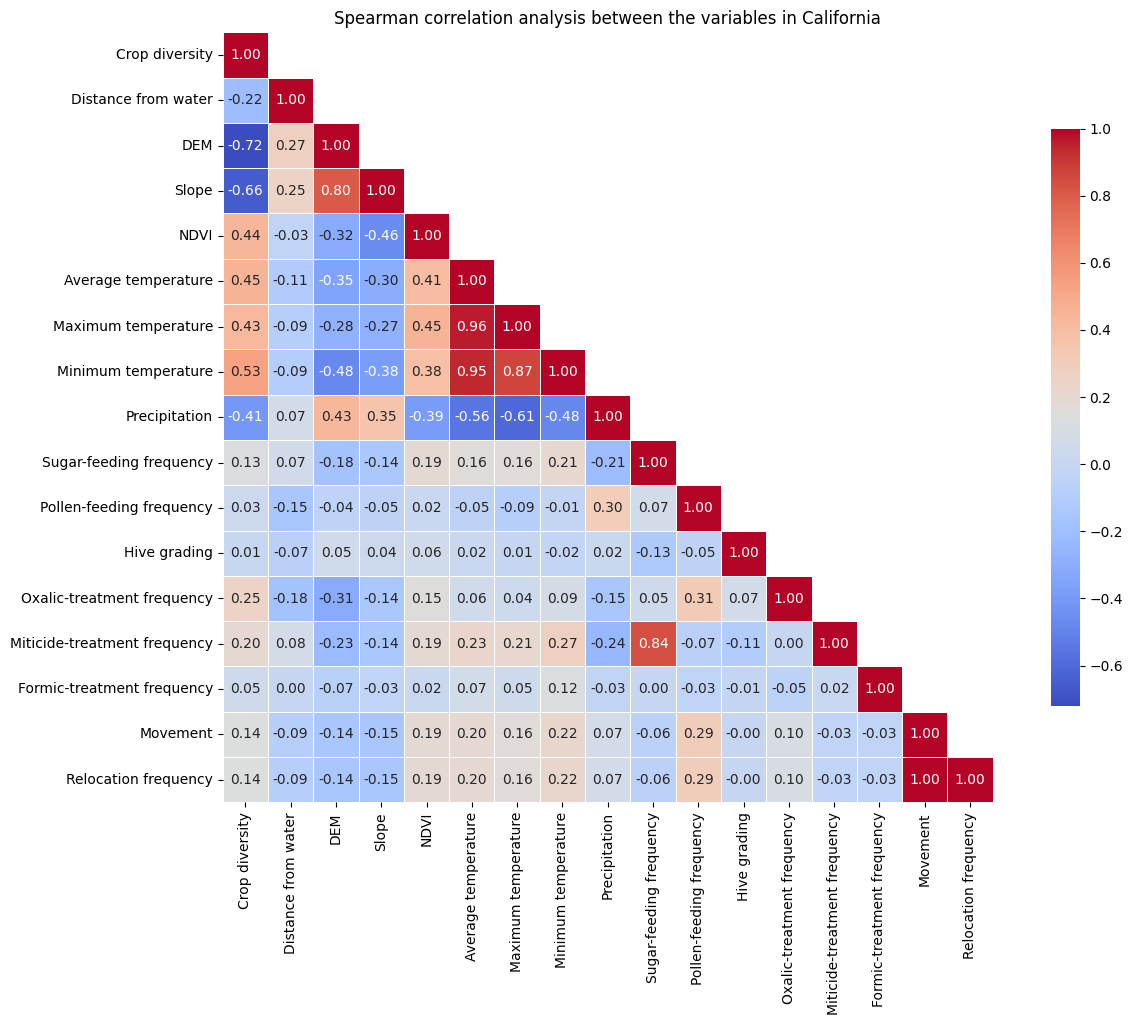

In [ ]:
# Setting up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plotting the heatmap with the mask and correct aspect ratio for the variables in California
sns.heatmap(corr_matrix_CA, mask=mask_CA, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": 0.75}, linewidths=0.5)

plt.title('Spearman correlation analysis between the variables in California')
plt.show()

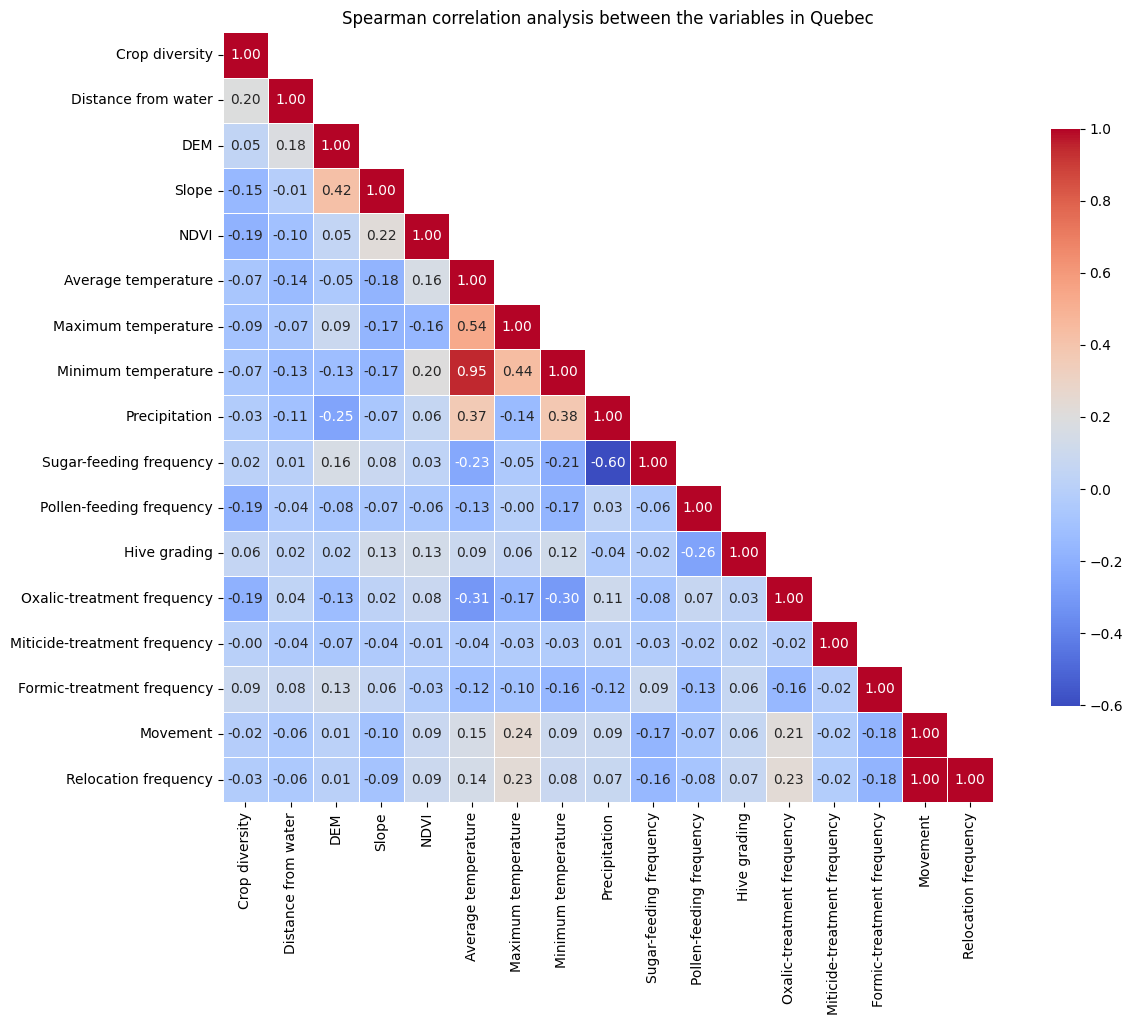

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix_QC, mask=mask_QC, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": 0.75}, linewidths=0.5)
plt.title('Spearman correlation analysis between the variables in Quebec')
plt.show()

In [ ]:
# Calculating VIF and Tolerance
def calculate_vif(df):
  # Adding a constant column for the intercept
  df_with_constant = sm.add_constant(df)

  # Calculating VIF for each feature
  vif_data = pd.DataFrame()
  vif_data['Feature'] = df.columns
  vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i+1) for i in range(len(df.columns))]
  vif_data['Tolerance'] = 1 / vif_data['VIF']

  return vif_data

# Using the function to calculate VIF and Tolerance
vif_California = calculate_vif(Processed_df_California.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude','Months']))
vif_Quebec = calculate_vif(Processed_df_Quebec.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude','Months']))

print('California VIF evaluation')
print(vif_California)

print('Quebec VIF evaluation')
print(vif_Quebec)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


California VIF evaluation
                         Feature          VIF  Tolerance
0                 Crop diversity     4.108501   0.243398
1            Distance from roads          NaN        NaN
2            Distance from water     1.136443   0.879938
3                            DEM     3.146265   0.317837
4                          Slope     2.928249   0.341501
5                           NDVI     1.591305   0.628415
6            Average temperature  1359.559821   0.000736
7            Maximum temperature   583.915262   0.001713
8            Minimum temperature   196.178731   0.005097
9                  Precipitation     2.089854   0.478502
10       Sugar-feeding frequency     4.532430   0.220632
11      Pollen-feeding frequency     1.455027   0.687273
12                  Hive grading     1.094154   0.913948
13    Oxalic-treatment frequency     1.351628   0.739849
14  Miticide-treatment frequency     4.802856   0.208209
15    Formic-treatment frequency     1.026626   0.974065
16   

# Splitting data into training and testing datasets

In [ ]:
# Reading main dataframes after being preprocessed and ready to be splitted into training and testing datasets
Processed_df_California = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Processed_df_California.csv")
Processed_df_Quebec = pd.read_csv("/content/drive/My Drive/Beehive_mortality/Processed_df_Quebec.csv")

In [ ]:
#Splitting datasets for the configuration including beehive management criteria
def splitting_data(dataframe, study_area):
  # Dropping columns with VIF greater than 5 for each study area
  if study_area == 'California':
    X = np.array(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature', 'Movement', 'Relocation frequency']))
  else:
    X = np.array(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                            'Average temperature', 'Minimum temperature', 'Movement', 'Relocation frequency']))

  # Structured array of target variable
  Y = Surv.from_arrays(dataframe['Event'], dataframe['hive_age'])  # survival outcome (event and time)

  # Initial split: Training and Testing datasets (70:30)
  X_training, X_testing, Y_training, Y_testing = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=0)

  if study_area == 'California':
    Y_training['time'] = np.clip(Y_training['time'], None, 335.0)
    Y_testing['time'] = np.clip(Y_testing['time'], None, 335.0)

  # Shape of datasets
  print('X_training shape: ', X_training.shape)
  print('Y_training shape: ', Y_training.shape)
  print('X_testing shape: ', X_testing.shape)
  print('Y_testing shape: ', Y_testing.shape)

  # Converting structured arrays to DataFrames
  def convert_to_dataframe(Y_data):
    Y_df = pd.DataFrame(Y_data)
    Y_df['Event'] = Y_df['event'].astype(int)
    Y_df.rename(columns={'time': 'hive_age'}, inplace=True)
    Y_df['hive_age'] = Y_df['hive_age'].astype(int)
    Y_df.drop(columns=['event'], inplace=True)
    return Y_df

  Y_training_df = convert_to_dataframe(Y_training)
  Y_testing_df = convert_to_dataframe(Y_testing)

  # Defining the new order of columns
  new_columns_order = ['Event', 'hive_age']

  # Creating DataFrames for training and testing datasets
  if study_area == 'California':
    column_list = list(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                                  'Average temperature', 'Maximum temperature', 'Minimum temperature', 'Movement', 'Relocation frequency']).columns)
  else:
    column_list = list(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                                  'Average temperature', 'Minimum temperature', 'Movement', 'Relocation frequency']).columns)

  data_training = pd.concat([Y_training_df, pd.DataFrame(X_training)], axis=1)
  data_training.columns = ['Event', 'hive_age'] + column_list

  data_testing = pd.concat([Y_testing_df, pd.DataFrame(X_testing)], axis=1)
  data_testing.columns = ['Event', 'hive_age'] + column_list

  return X_training, X_testing, Y_training, Y_testing, data_training, data_testing

In [ ]:
# Applying splitting_data function to split training dataset from testing for the configuration including beehive management criteria
X_training_CA, X_testing_CA, Y_training_CA, Y_testing_CA, data_training_CA, data_testing_CA = splitting_data(Processed_df_California, 'California')
X_training_QC, X_testing_QC, Y_training_QC, Y_testing_QC, data_training_QC, data_testing_QC = splitting_data(Processed_df_Quebec, 'Quebec')

X_training shape:  (16175, 13)
Y_training shape:  (16175,)
X_testing shape:  (6933, 13)
Y_testing shape:  (6933,)
X_training shape:  (15817, 14)
Y_training shape:  (15817,)
X_testing shape:  (6779, 14)
Y_testing shape:  (6779,)


In [ ]:
# Splitting datasets for the configuration excluding beehive management criteria
def splitting_data_2(dataframe, study_area):
  # Dropping columns with VIF greater than 5 for each study area
  if study_area == 'California':
    X = np.array(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']))
  else:
    X = np.array(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                            'Average temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']))

  # Structured array of target variable
  Y = Surv.from_arrays(dataframe['Event'], dataframe['hive_age'])  # survival outcome (event and time)

  # Initial split: Training and Testing datasets (70:30)
  X_training, X_testing, Y_training, Y_testing = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=0)

  if study_area == 'California':
    Y_training['time'] = np.clip(Y_training['time'], None, 335.0)
    Y_testing['time'] = np.clip(Y_testing['time'], None, 335.0)

  # Shape of datasets
  print('X_training shape: ', X_training.shape)
  print('Y_training shape: ', Y_training.shape)
  print('X_testing shape: ', X_testing.shape)
  print('Y_testing shape: ', Y_testing.shape)

  # Converting structured arrays to DataFrames
  def convert_to_dataframe(Y_data):
    Y_df = pd.DataFrame(Y_data)
    Y_df['Event'] = Y_df['event'].astype(int)
    Y_df.rename(columns={'time': 'hive_age'}, inplace=True)
    Y_df['hive_age'] = Y_df['hive_age'].astype(int)
    Y_df.drop(columns=['event'], inplace=True)
    return Y_df

  Y_training_df = convert_to_dataframe(Y_training)
  Y_testing_df = convert_to_dataframe(Y_testing)

  # Defining the new order of columns
  new_columns_order = ['Event', 'hive_age']

  # Creating DataFrames for training and testing datasets
  if study_area == 'California':
    column_list = list(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']).columns)
  else:
    column_list = list(dataframe.drop(columns=['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Distance from roads',
                                            'Average temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']).columns)

  data_training = pd.concat([Y_training_df, pd.DataFrame(X_training)], axis=1)
  data_training.columns = ['Event', 'hive_age'] + column_list

  data_testing = pd.concat([Y_testing_df, pd.DataFrame(X_testing)], axis=1)
  data_testing.columns = ['Event', 'hive_age'] + column_list

  return X_training, X_testing, Y_training, Y_testing, data_training, data_testing

In [ ]:
# Applying splitting_data_2 function to split training dataset from testing for the configuration excluding beehive management criteria
X_training_CA_2, X_testing_CA_2, Y_training_CA_2, Y_testing_CA_2, data_training_CA_2, data_testing_CA_2 = splitting_data_2(Processed_df_California, 'California')
X_training_QC_2, X_testing_QC_2, Y_training_QC_2, Y_testing_QC_2, data_training_QC_2, data_testing_QC_2 = splitting_data_2(Processed_df_Quebec, 'Quebec')

X_training shape:  (16175, 7)
Y_training shape:  (16175,)
X_testing shape:  (6933, 7)
Y_testing shape:  (6933,)
X_training shape:  (15817, 8)
Y_training shape:  (15817,)
X_testing shape:  (6779, 8)
Y_testing shape:  (6779,)


# Training random survival forest (RSF) models and their accuracy evaluation under two criteria configurations

Model training

California

In [ ]:
# Optimizing hyper-parameters for the RSF using California dataset
parameters_CA = {'n_estimators':np.arange(100,500,50), 'max_depth':np.arange(1,30,4)}
RSF_CA = RandomSurvivalForest(random_state=0, bootstrap = True)
RSF_model_gs_CA = GridSearchCV(RSF_CA, parameters_CA, cv=5, return_train_score=True, n_jobs=-1)
RSF_model_gs_CA.fit(X_training_CA, Y_training_CA)
RSF_model_gs_CA.best_params_

# Printing the best hyperparameters found
print("Best hyperparameters:", RSF_model_gs_CA.best_params_)
print("\n")

# Printing the best cross-validated score
print("Best cross-validated score (concordance index):", RSF_model_gs_CA.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'max_depth': 29, 'n_estimators': 450}


Best cross-validated score (concordance index): 0.8994954095335685


In [ ]:
# Fitting a RSF model to the training dataset having found the optimized values for the hyper-parameters
# the configuration including beehive management criteria
RSF_model_CA = RandomSurvivalForest(random_state=0, n_estimators = 450, max_depth = 29, bootstrap = True)
RSF_model_CA.fit(X_training_CA, Y_training_CA)

RandomSurvivalForest(max_depth=29, n_estimators=450, random_state=0)

In [ ]:
# Fitting a RSF model to the training dataset having found the optimized values for the hyper-parameters
# the configuration excluding beehive management criteria
RSF_model_CA_2 = RandomSurvivalForest(random_state=0, n_estimators = 450, max_depth = 29, bootstrap = True)
RSF_model_CA_2.fit(X_training_CA_2, Y_training_CA_2)

RandomSurvivalForest(max_depth=29, n_estimators=450, random_state=0)

Quebec

In [ ]:
# Optimizing hyper-parameters for the RSF model using Quebec dataset
parameters_QC = {'n_estimators':np.arange(100,500,50), 'max_depth':np.arange(1,30,4)}
RSF_QC = RandomSurvivalForest(random_state=0, bootstrap = True)
RSF_model_gs_QC = GridSearchCV(RSF_QC, parameters_QC, cv=5, return_train_score=True, n_jobs=-1)
RSF_model_gs_QC.fit(X_training_QC, Y_training_QC)
RSF_model_gs_QC.best_params_

# Printing the best hyperparameters found
print("Best hyperparameters:", RSF_model_gs_QC.best_params_)
print("\n")

# Printing the best cross-validated score
print("Best cross-validated score (concordance index):", RSF_model_gs_QC.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters: {'max_depth': 13, 'n_estimators': 400}


Best cross-validated score (concordance index): 0.9636265972733835


In [ ]:
# Fitting a RSF model to the training dataset having found the optimized values for the hyper-parameters
# the configuration including beehive management criteria
RSF_model_QC = RandomSurvivalForest(random_state=0, n_estimators = 400, max_depth = 13, bootstrap = True)
RSF_model_QC.fit(X_training_QC, Y_training_QC)

RandomSurvivalForest(max_depth=13, n_estimators=400, random_state=0)

In [ ]:
# Fitting a RSF model to the training dataset having found the optimized values for the hyper-parameters
# the configuration excluding beehive management criteria
RSF_model_QC_2 = RandomSurvivalForest(random_state=0, n_estimators = 400, max_depth = 13, bootstrap = True)
RSF_model_QC_2.fit(X_training_QC_2, Y_training_QC_2)

RandomSurvivalForest(max_depth=13, n_estimators=400, random_state=0)

Evaluation of models' accuracy

In [ ]:
# Calibration function
def calibrate_rsf_model(rsf_model, X_training, Y_training):
  # Predict survival probabilities on the training data
  pred_surv_probs = rsf_model.predict_survival_function(X_training, return_array=True)

  # Prepare the true survival probabilities for calibration
  Y_training_real = Surv.from_arrays(event=Y_training['event'], time=Y_training['time'])
  unique_times_real = np.unique(Y_training['time'])
  mean_true_surv_probs = np.array([np.mean(Y_training['time'] >= t) for t in unique_times_real])

  # Interpolate predicted probabilities to align with the true survival times
  interp_func = interp1d(rsf_model.unique_times_, np.mean(pred_surv_probs, axis=0), kind='nearest', fill_value='extrapolate')
  pred_surv_probs_interp = interp_func(unique_times_real)

  # Apply isotonic regression for calibration
  iso_reg = IsotonicRegression(out_of_bounds='clip')
  iso_reg.fit(pred_surv_probs_interp, mean_true_surv_probs)
  calibrated_pred_surv_probs = iso_reg.transform(pred_surv_probs_interp)

  return calibrated_pred_surv_probs, unique_times_real


In [ ]:
def evaluation_model(model, X_train, X_test, Y_train, Y_test):
  # Calibrating the model using the training set
  calibrated_pred_surv_probs, unique_times_real = calibrate_rsf_model(model, X_train, Y_train)

  # Calculating the Concordance index (C-index)
  c_index = concordance_index_censored(Y_test["event"], Y_test["time"], model.predict(X_test))
  print("Concordance index (C-index):", c_index[0])

  # Getting the probability of event-free survival for the testing dataset (apply calibration)
  surv_funcs = model.predict_survival_function(X_test)

  # Finding the range of follow-up times in Y_test
  min_time_test = int(Y_test['time'].min())
  max_time_test = int(Y_test['time'].max())

  # Ensuring that times are within the follow-up time range of Y_test
  times = np.array([t for t in model.unique_times_ if min_time_test <= t < max_time_test])
  preds = np.asarray([[fn(t) for t in times] for fn in surv_funcs])

  if len(times) == 0:
    raise ValueError("No times found within the follow-up range.")

  # Computing the integrated Brier score (IBS) using calibrated probabilities
  ibs = integrated_brier_score(Y_train, Y_test, preds, times)
  print("Integrated Brier Score (IBS):", ibs)

  # Calculating Time-dependent AUC (apply calibration)
  aucs_test = cumulative_dynamic_auc(Y_train, Y_test, model.predict(X_test), times)[0]

  # Handling NaN values in AUCs
  valid_indices_test = ~np.isnan(aucs_test)
  valid_aucs_test = aucs_test[valid_indices_test]

  # Calculating the mean AUC over the entire time range
  mean_auc_test = np.mean(valid_aucs_test)
  print("Mean Time-dependent AUC:", mean_auc_test)

  return c_index, mean_auc_test, ibs

Model evaluation results on both training and test datasets

In [ ]:
# Accuracy on the training dataset
# The configuration including beehive management criteria
c_index_CA, Time_dependent_CA, ibs_CA = evaluation_model(model = RSF_model_CA, X_train = X_training_CA, X_test = X_training_CA, Y_train = Y_training_CA, Y_test = Y_training_CA)
c_index_QC, Time_dependent_QC, ibs_QC = evaluation_model(model = RSF_model_QC, X_train = X_training_QC, X_test = X_training_QC, Y_train = Y_training_QC, Y_test = Y_training_QC)

Concordance index (C-index): 0.9103021249418157
Integrated Brier Score (IBS): 0.012388622878229994


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean Time-dependent AUC: 0.9034455707665686
Concordance index (C-index): 0.9824605403311707
Integrated Brier Score (IBS): 0.009301547785696406
Mean Time-dependent AUC: 0.9860725554968841


In [ ]:
# Accuracy on the test dataset
#the configuration including beehive management criteria
c_index_CA, c_index_td_CA, ibs_CA = evaluation_model(model = RSF_model_CA, X_train = X_training_CA, X_test = X_testing_CA, Y_train = Y_training_CA, Y_test = Y_testing_CA)
c_index_QC, c_index_td_QC, ibs_QC = evaluation_model(model = RSF_model_QC, X_train = X_training_QC, X_test = X_testing_QC, Y_train = Y_training_QC, Y_test = Y_testing_QC)

Concordance index (C-index): 0.8844667091379997
Integrated Brier Score (IBS): 0.017719802662403288


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean Time-dependent AUC: 0.8819163371306032
Concordance index (C-index): 0.9618223456214661
Integrated Brier Score (IBS): 0.012074148708822643
Mean Time-dependent AUC: 0.968682179039571


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


In [ ]:
# Accuracy on the training dataset
# The configuration excluding beehive management criteria
c_index_CA_2, c_index_td_CA_2, ibs_CA_2 = evaluation_model(model = RSF_model_CA_2, X_train = X_training_CA_2, X_test = X_training_CA_2, Y_train = Y_training_CA_2, Y_test = Y_training_CA_2)
c_index_QC_2, c_index_td_QC_2, ibs_QC_2 = evaluation_model(model = RSF_model_QC_2, X_train = X_training_QC_2, X_test = X_training_QC_2, Y_train = Y_training_QC_2, Y_test = Y_training_QC_2)

Concordance index (C-index): 0.8394134102834132
Integrated Brier Score (IBS): 0.01947537586568522


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean Time-dependent AUC: 0.8477964171274494
Concordance index (C-index): 0.9690279526161195
Integrated Brier Score (IBS): 0.0122679079197754
Mean Time-dependent AUC: 0.9718552623984038


In [ ]:
# Accuracy on the test dataset
# The configuration excluding beehive management criteria
c_index_CA_2, c_index_td_CA_2, ibs_CA_2 = evaluation_model(model = RSF_model_CA_2,  X_train = X_training_CA_2, X_test = X_testing_CA_2, Y_train = Y_training_CA_2, Y_test = Y_testing_CA_2)
c_index_QC_2, c_index_td_QC_2, ibs_QC_2 = evaluation_model(model = RSF_model_QC_2,  X_train = X_training_QC_2, X_test = X_testing_QC_2, Y_train = Y_training_QC_2, Y_test = Y_testing_QC_2)

Concordance index (C-index): 0.8043404168422325
Integrated Brier Score (IBS): 0.027254291185165692


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean Time-dependent AUC: 0.824741656690583
Concordance index (C-index): 0.9402934560119977
Integrated Brier Score (IBS): 0.015420174977064629
Mean Time-dependent AUC: 0.9508215765569344


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Plotting Time-dependent AUC

In [ ]:
def Plotting_AUC(model, X_train, X_test, Y_train, Y_test, state):
  # Calibrating the model using the training set
  calibrated_pred_surv_probs, unique_times_real = calibrate_rsf_model(model, X_train, Y_train)

  # Finding the range of follow-up times in Y_train and Y_test
  min_time_train = int(Y_train['time'].min())
  max_time_train = int(Y_train['time'].max())

  min_time_test = int(Y_test['time'].min())
  max_time_test = int(Y_test['time'].max())

  # Ensuring times are within the follow-up time range
  times = np.array([t for t in model.unique_times_ if min_time_train <= t < max_time_test])

  if len(times) == 0:
      raise ValueError("No times found within the follow-up range.")

  # Calculating time-dependent AUC for training and test datasets
  aucs_train = cumulative_dynamic_auc(Y_train, Y_train, model.predict(X_train), times)[0]
  aucs_test = cumulative_dynamic_auc(Y_train, Y_test, model.predict(X_test), times)[0]

  # Excluding NaN values from AUCs
  valid_aucs_train = aucs_train[~np.isnan(aucs_train)]
  valid_aucs_test = aucs_test[~np.isnan(aucs_test)]

  # Calculating the mean AUC over the entire time range
  mean_auc_train = np.mean(valid_aucs_train)
  mean_auc_test = np.mean(valid_aucs_test)

  print("Mean AUC Training:", mean_auc_train)
  print("Mean AUC Test:", mean_auc_test)

  # Plotting the Time-dependent AUC for all datasets
  plt.figure(figsize=(10, 6))
  plt.plot(times, aucs_train, label='Training dataset')
  plt.plot(times, aucs_test, label='Test dataset')
  plt.xlabel('Hive age (days)', fontsize=14)
  plt.ylabel('Time-dependent AUC', fontsize=14)
  # Set custom y-ticks
  plt.yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=12)
  plt.xticks(fontsize=12)
  plt.title(f'Time-dependent AUC curve for the configuration including beehive management criteria in {state}', fontsize=14)
  plt.legend()
  plt.grid(False)
  plt.show()

/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]
/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean AUC Training: 0.9034455707665686
Mean AUC Test: 0.8819163371306032


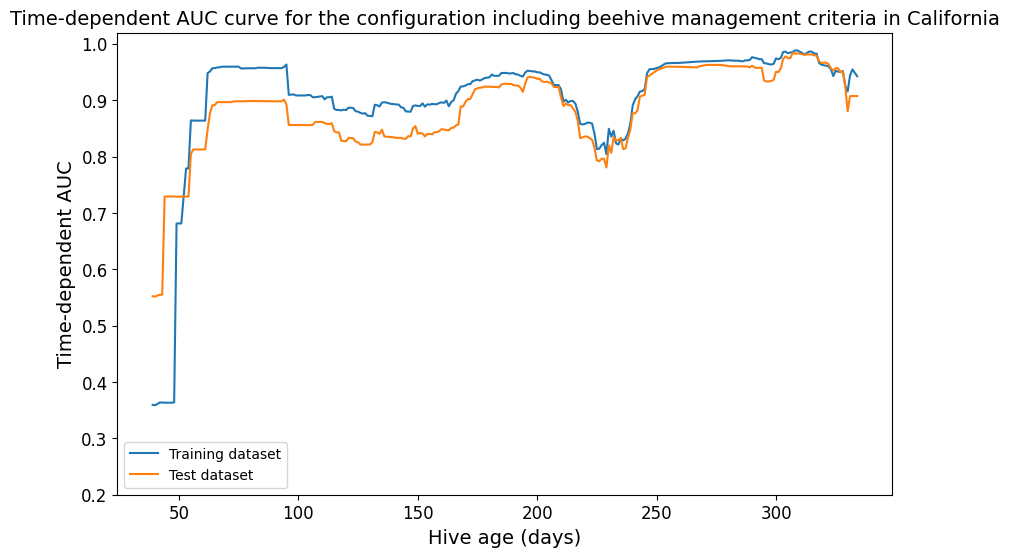

/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean AUC Training: 0.9860725554968841
Mean AUC Test: 0.968682179039571


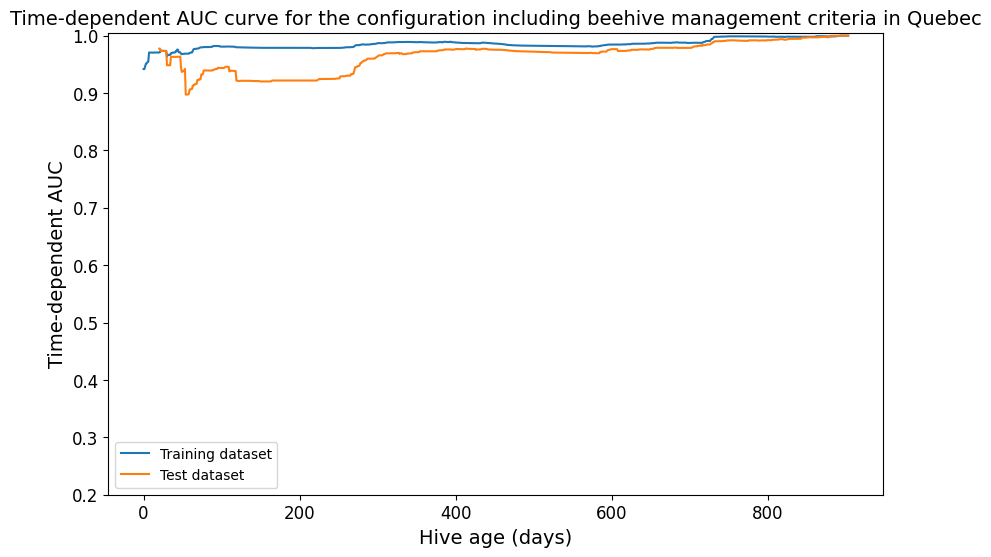

In [ ]:
# Plotting the Time-dependent AUC for the configuration including beehive management criteria
Plotting_AUC(model = RSF_model_CA, X_train = X_training_CA, X_test = X_testing_CA, Y_train = Y_training_CA, Y_test = Y_testing_CA, state = 'California')
Plotting_AUC(model = RSF_model_QC, X_train = X_training_QC,  X_test = X_testing_QC, Y_train = Y_training_QC, Y_test = Y_testing_QC, state = 'Quebec')

/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean AUC Training: 0.8477964171274494
Mean AUC Test: 0.824741656690583


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


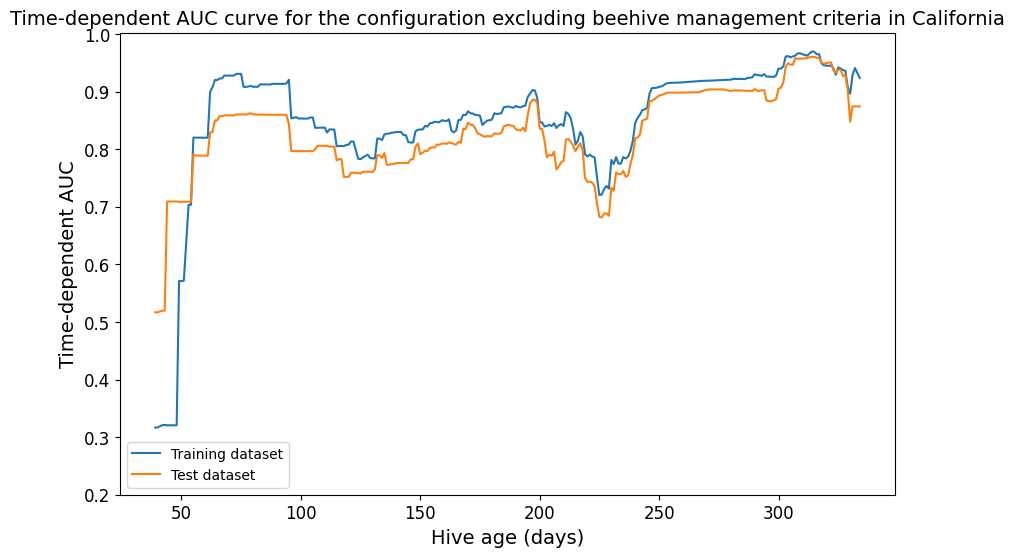

/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


Mean AUC Training: 0.9718552623984038
Mean AUC Test: 0.9508215765569344


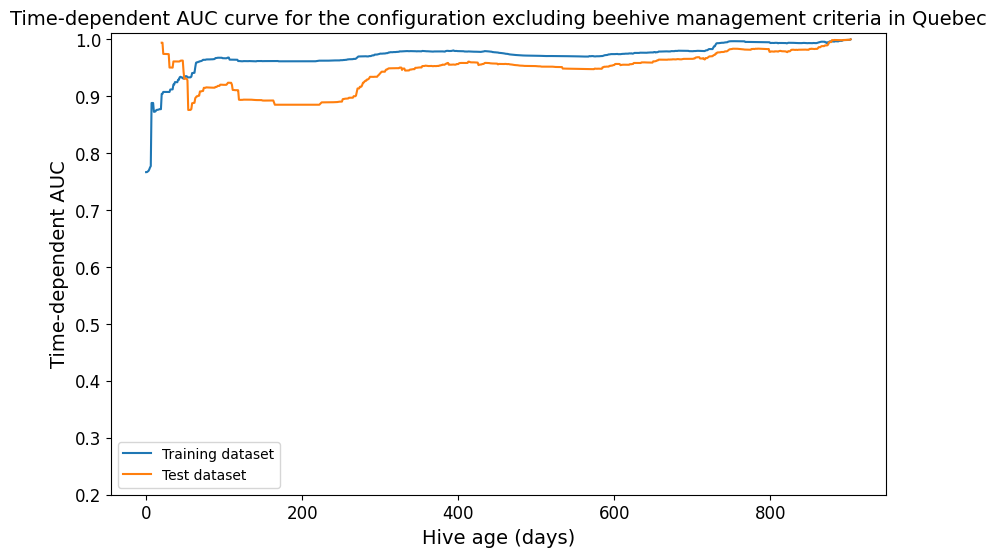

In [ ]:
# Plotting the Time-dependent AUC for the configuration excluding beehive management criteria
Plotting_AUC(model = RSF_model_CA_2, X_train = X_training_CA_2, X_test = X_testing_CA_2, Y_train = Y_training_CA_2, Y_test = Y_testing_CA_2, state = 'California')
Plotting_AUC(model = RSF_model_QC_2, X_train = X_training_QC_2, X_test = X_testing_QC_2, Y_train = Y_training_QC_2, Y_test = Y_testing_QC_2, state = 'Quebec')

# Plotting survival probability curves

In [ ]:
# Function to create a Taylor Diagram
class TaylorDiagram:
    def __init__(self, std_obs, fig=None, rect=111, label="Observation", srange=(0, 1.5)):
        """
        Initialize Taylor Diagram.
        """
        self.ref_std = std_obs  # Reference standard deviation

        # Create polar axes
        if fig is None:
            fig = plt.figure(figsize=(8, 8))
        self.ax = fig.add_subplot(rect, polar=True)

        self.ax.set_ylim(0, srange[1])  # Set radius limits
        self.ax.set_ylabel("Standard Deviation", fontsize=12)
        self.ax.set_xlabel("Standard Deviation", fontsize=12, labelpad=20)
        self.ax.set_thetamin(-5)  # Set the minimum angle to -10 degrees
        self.ax.set_thetamax(90)   # Set the maximum angle to 90 degrees
        # Add reference point (observation point)
        self.ax.plot([0], [self.ref_std], 'go', label=label, markersize=12, markeredgecolor='g', markeredgewidth=2)

    def add_sample(self, rmse, stddev, corrcoef, label, xy_x, xy_y, marker='o', color='b'):
        """
        Add a sample to the diagram.
        """
        theta = np.arccos(corrcoef)  # Correlation angle
        self.ax.plot(theta, stddev, marker, label=label, color=color)
        self.ax.annotate(f"RMSE: {rmse:.3f}; SD: {stddev:.3f}",
                         xy=(theta, stddev),
                         textcoords='offset points',
                         xytext=(xy_x, xy_y),
                         ha='left',
                         va='bottom',
                         color = color,
                         fontsize=12)

    def add_contours(self, levels=10, **kwargs):
        """
        Add RMSE contours.
        """
        theta = np.linspace(0, np.pi / 2, 100)
        rmse_contours = []
        for std in np.linspace(0.5, 1.5, levels):
            r = np.sqrt(self.ref_std**2 + std**2 - 2 * self.ref_std * std * np.cos(theta))
            rmse_contours.append(r)
            self.ax.plot(theta, r, linestyle='--', **kwargs)

        return rmse_contours

In [ ]:
def plotting_survival_probability_with_taylor(model, model_without, X, X_without, Y, state):
  # Convert the structured array to the Surv object
  Y_real = Surv.from_arrays(event=Y['event'], time=Y['time'])

  # True survival function
  unique_times_real = np.unique(Y['time'])
  mean_true_surv_probs = [np.mean(Y['time'] >= t) for t in unique_times_real]
  std_true_surv_probs = [np.std(Y['time'] >= t) for t in unique_times_real]

  # Convert to numpy arrays
  mean_true_surv_probs = np.array(mean_true_surv_probs)
  std_true_surv_probs = np.array(std_true_surv_probs)

  # Predict survival probabilities for the test dataset including beehive management criteria
  surv_test = model.predict_survival_function(X, return_array=True)
  unique_times_pred = model.unique_times_

  # Interpolate the predicted survival probabilities to align with the true time points
  interp_func = interp1d(unique_times_pred, np.mean(surv_test, axis=0), kind='nearest', fill_value='extrapolate')
  pred_surv_probs_interp = interp_func(unique_times_real)

  # Apply isotonic regression for calibration
  iso_reg = IsotonicRegression(out_of_bounds='clip')
  iso_reg.fit(pred_surv_probs_interp, mean_true_surv_probs)
  calibrated_pred_surv_probs = iso_reg.transform(pred_surv_probs_interp)

  # Do the same for the configuration excluding beehive management criteria
  surv_test_without = model_without.predict_survival_function(X_without, return_array=True)
  unique_times_pred_without = model_without.unique_times_

  interp_func_without = interp1d(unique_times_pred_without, np.mean(surv_test_without, axis=0), kind='nearest', fill_value='extrapolate')
  pred_surv_probs_without_interp = interp_func_without(unique_times_real)

  # Apply isotonic regression for the model without beehive management
  calibrated_pred_surv_probs_without = iso_reg.transform(pred_surv_probs_without_interp)

  # Plotting survival probability curves
  plt.figure(figsize=(10, 6))

  # Plotting true survival probabilities
  plt.plot(unique_times_real, mean_true_surv_probs, drawstyle="steps-post", color='g', label='True mean survival probability')
  plt.fill_between(unique_times_real, mean_true_surv_probs - std_true_surv_probs, mean_true_surv_probs + std_true_surv_probs,
                  step="post", alpha=0.1, color='g')

  # Plotting calibrated survival probabilities with beehive management criteria
  plt.plot(unique_times_real, calibrated_pred_surv_probs, drawstyle="steps-post", color='b', label='Predicted survival with beehive management criteria')
  plt.fill_between(unique_times_real, calibrated_pred_surv_probs - std_true_surv_probs, calibrated_pred_surv_probs + std_true_surv_probs,
                  step="post", alpha=0.1, color='b')

  # Plotting calibrated survival probabilities without beehive management criteria
  plt.plot(unique_times_real, calibrated_pred_surv_probs_without, drawstyle="steps-post", color='r', label='Predicted survival without beehive management criteria')
  plt.fill_between(unique_times_real, calibrated_pred_surv_probs_without - std_true_surv_probs, calibrated_pred_surv_probs_without + std_true_surv_probs,
                  step="post", alpha=0.1, color='r')

  plt.ylabel("Survival probability", fontsize=14)
  plt.xlabel("Hive age (days)", fontsize=14)
  plt.xticks(fontsize=12, rotation=90)
  plt.yticks(fontsize=12)
  plt.title(f"Comparison of True and Predicted Survival Probabilities in {state}", fontsize=14)
  plt.grid(False)
  plt.legend(loc='lower right', fontsize=11)
  plt.show()

  # Correlation and Standard Deviations
  std_obs = np.std(mean_true_surv_probs)
  std_with = np.std(calibrated_pred_surv_probs)
  std_without = np.std(calibrated_pred_surv_probs_without)

  rmse_with = np.sqrt(np.mean((mean_true_surv_probs - calibrated_pred_surv_probs) ** 2))
  rmse_without = np.sqrt(np.mean((mean_true_surv_probs - calibrated_pred_surv_probs_without) ** 2))

  corr_with = spearmanr(mean_true_surv_probs, calibrated_pred_surv_probs)[0]
  corr_without = spearmanr(mean_true_surv_probs, calibrated_pred_surv_probs_without)[0]

  # Create Taylor Diagram
  fig = plt.figure(figsize=(8, 8))
  taylor = TaylorDiagram(std_obs, fig, rect=111, label="True mean survival probability")

  # Add samples
  taylor.add_sample(rmse_with, std_with, corr_with, label="Predicted survival with beehive management criteria", xy_x = 7, xy_y = -7, color="b")
  taylor.add_sample(rmse_without, std_without, corr_without, label="Predicted survival without beehive management criteria", xy_x = 7, xy_y = -7, color="r")

  # Add contours
  taylor.add_contours(levels=10, color="grey", alpha=0.5)

  # Add legend
  plt.legend(loc='upper right', fontsize=11)
  plt.title(f"Taylor diagram for {state}")
  plt.show()

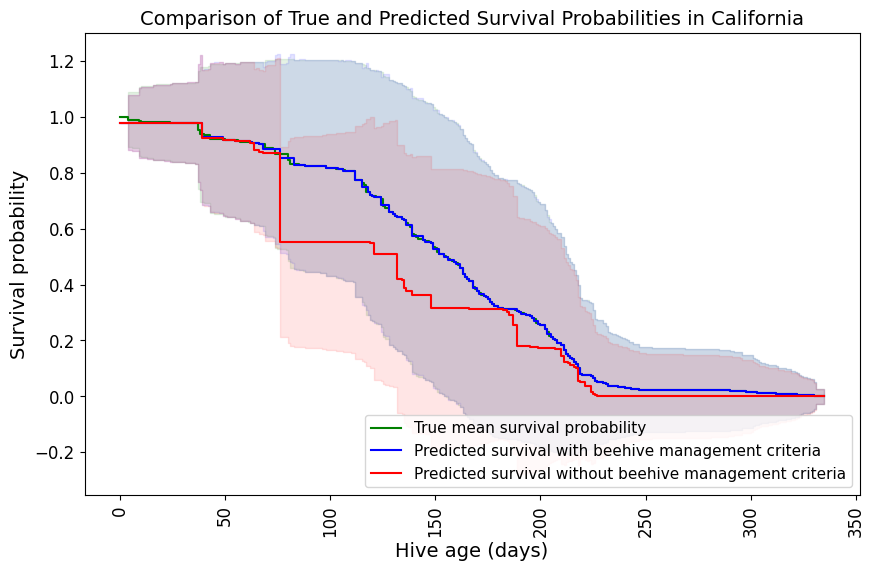

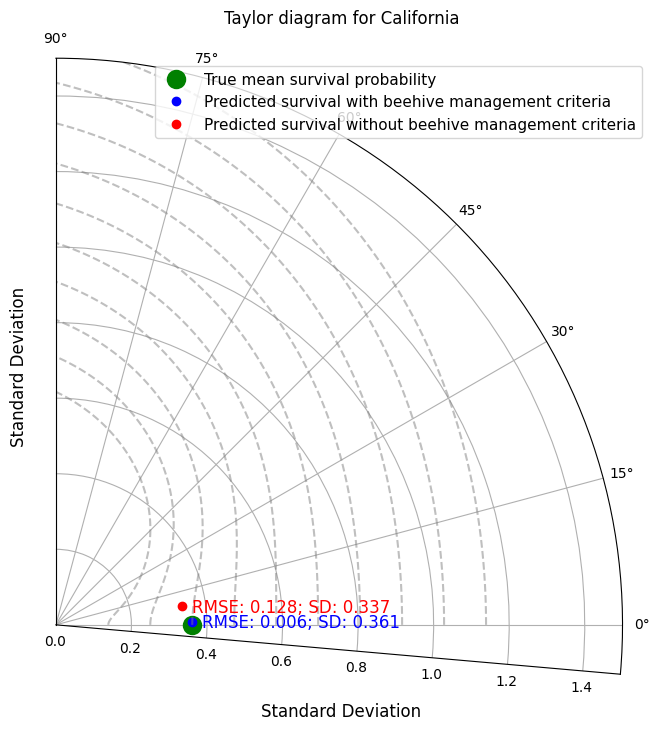

In [ ]:
# Plotting survival probability curves for both criteria configurations in California
plotting_survival_probability_with_taylor(RSF_model_CA, RSF_model_CA_2, X_testing_CA, X_testing_CA_2, Y_testing_CA, state = 'California')

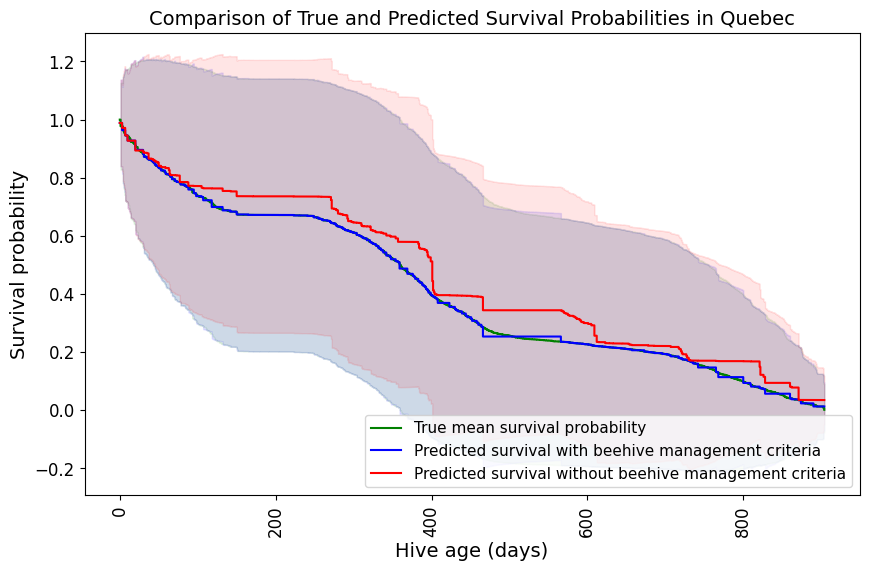

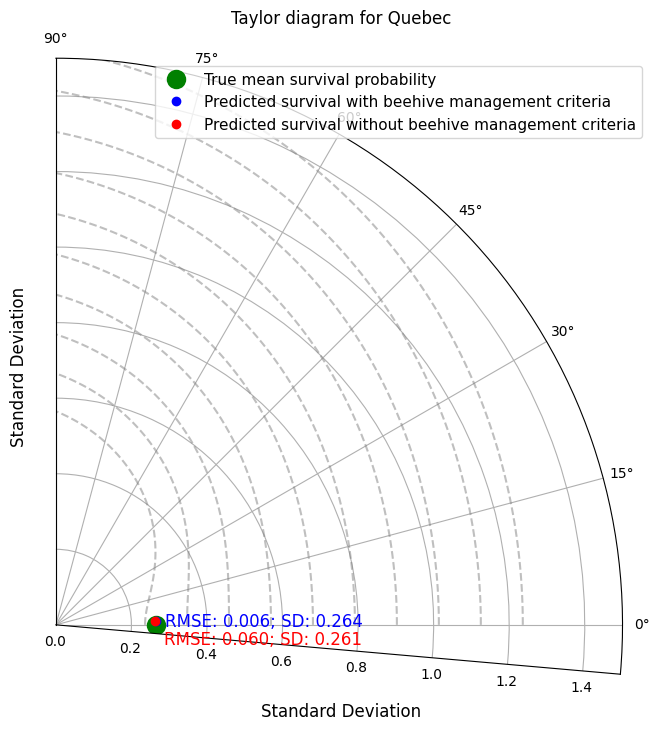

In [ ]:
# Plotting survival probability curves for both criteria configurations in Quebec
plotting_survival_probability_with_taylor(RSF_model_QC, RSF_model_QC_2, X_testing_QC, X_testing_QC_2, Y_testing_QC, state = 'Quebec')

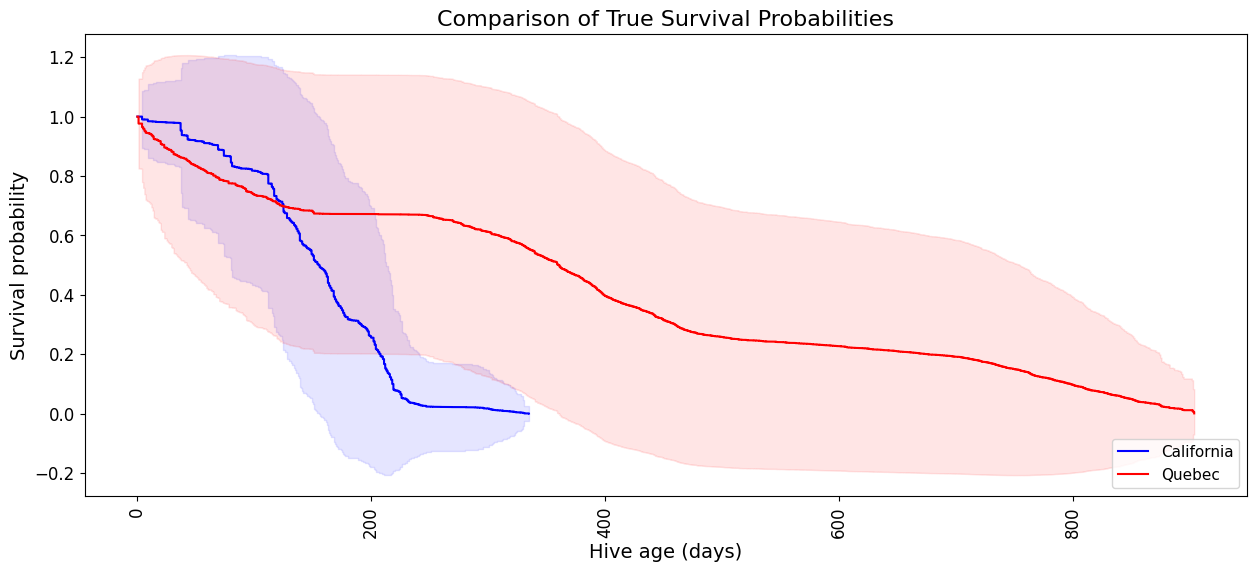

In [ ]:
# Comparison of true survival probabilities of beehives in two study areas, California and Quebec
CA_Vs_QC = pd.read_csv("/content/CA_Vs_QC.csv")
unique_times_real_CA = np.array(CA_Vs_QC['unique_times_real_CA'])
unique_times_real_QC = np.array(CA_Vs_QC['unique_times_real_QC'])

mean_true_surv_probs_CA=np.array(CA_Vs_QC['mean_true_surv_probs_CA'])
std_true_surv_probs_CA=np.array(CA_Vs_QC['std_true_surv_probs_CA'])

mean_true_surv_probs_QC=np.array(CA_Vs_QC['mean_true_surv_probs_QC'])
std_true_surv_probs_QC=np.array(CA_Vs_QC['std_true_surv_probs_QC'])

plt.figure(figsize=(15, 6))

# Plotting true survival probability curve for the beehives in California
plt.plot(unique_times_real_CA, mean_true_surv_probs_CA, drawstyle="steps-post", color='b', label='California')
plt.fill_between(unique_times_real_CA, mean_true_surv_probs_CA - std_true_surv_probs_CA, mean_true_surv_probs_CA + std_true_surv_probs_CA,
                step="post", alpha=0.1, color='b')

# Plotting true survival probability curve for the beehives in Quebec
plt.plot(unique_times_real_QC, mean_true_surv_probs_QC, drawstyle="steps-post", color='r', label='Quebec')
plt.fill_between(unique_times_real_QC, mean_true_surv_probs_QC - std_true_surv_probs_QC, mean_true_surv_probs_QC + std_true_surv_probs_QC,
                step="post", alpha=0.1, color='r')

plt.ylabel("Survival probability", fontsize=14)
plt.xlabel("Hive age (days)", fontsize=14)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.title(f"Comparison of True Survival Probabilities", fontsize=16)
plt.grid(False)
plt.legend(loc='lower right', fontsize = 11)
plt.show()

# Variable importance assessment

In [ ]:
def feature_importance_evaluation_RSF_model(RSF_model, X, Y, dataframe, study_area):
    # Evaluating feature importance
    result = permutation_importance(RSF_model, X, Y, n_repeats=15)
    feature_importance_df = pd.DataFrame(
        {
            k: result[k]
            for k in ("importances_mean", "importances_std",)
        },
        index=dataframe.columns,
    ).sort_values(by="importances_mean", ascending=False)

    # Plotting error bars and line graph
    plt.figure(figsize=(12, 5))
    plt.gca().set_facecolor('white')
    plt.grid(False)

    # Error bars
    plt.errorbar(
        x=feature_importance_df.index,
        y=feature_importance_df['importances_mean'],
        yerr=feature_importance_df['importances_std'],
        fmt='o', capsize=5, color='b'
    )

    # Line graph to connect the points
    plt.plot(
        feature_importance_df.index,
        feature_importance_df['importances_mean'],
        linestyle='-', marker=''
    )


    plt.xlabel('Features', fontsize = 12)
    plt.ylabel('Mean importance', fontsize = 12)
    plt.title(f'Importance of features in {study_area}, excluding beehive management criteria', fontsize = 14)
    plt.xticks(rotation=45, ha='right', fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.tight_layout()
    plt.show()

    return feature_importance_df



In [ ]:
# Using both training and test datasets in the variable/feature importance assessment
# The configuration including beehive management criteria
Dataframe_CA = Processed_df_California.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Months', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature', 'Movement', 'Relocation frequency'])
X_CA = np.array(Processed_df_California.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude', 'Months', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature', 'Movement', 'Relocation frequency']))
Y_CA = Surv.from_arrays(Processed_df_California['Event'], Processed_df_California['hive_age'])

Dataframe_QC = Processed_df_Quebec.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months','Distance from roads',
                                                  'Average temperature', 'Minimum temperature', 'Movement', 'Relocation frequency'])
X_QC = np.array(Processed_df_Quebec.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months','Distance from roads',
                                                  'Average temperature', 'Minimum temperature', 'Movement', 'Relocation frequency']))
Y_QC = Surv.from_arrays(Processed_df_Quebec['Event'], Processed_df_Quebec['hive_age'])

# The configuration excluding beehive management criteria
Dataframe_CA_2 = Processed_df_California.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency'])
X_CA_2 = np.array(Processed_df_California.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']))
Y_CA_2 = Surv.from_arrays(Processed_df_California['Event'], Processed_df_California['hive_age'])

Dataframe_QC_2 = Processed_df_Quebec.drop(columns = ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months','Distance from roads',
                                            'Average temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency'])
X_QC_2 = np.array(Processed_df_Quebec.drop(columns= ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months','Distance from roads',
                                            'Average temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']))
Y_QC_2 = Surv.from_arrays(Processed_df_Quebec['Event'], Processed_df_Quebec['hive_age'])

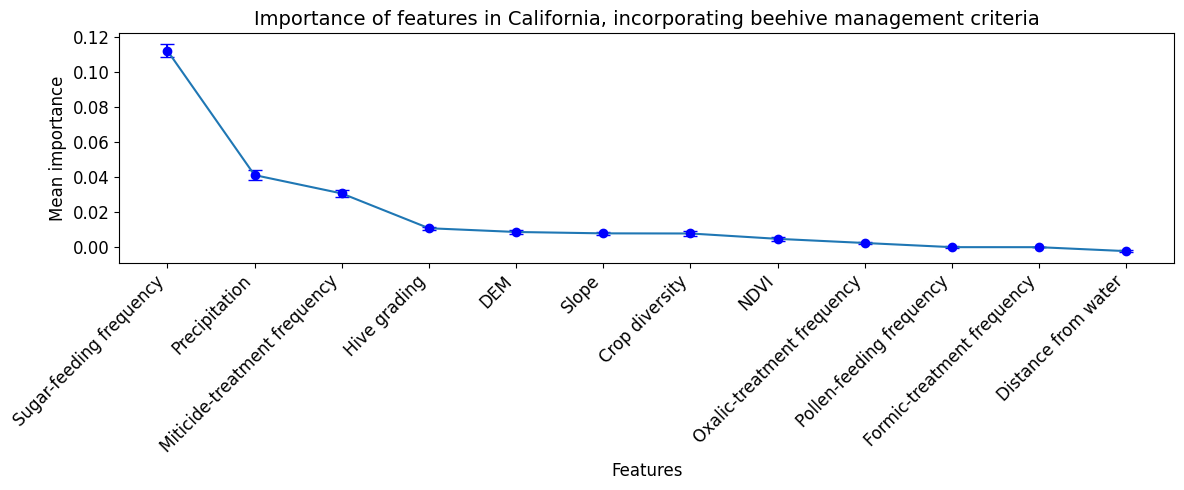

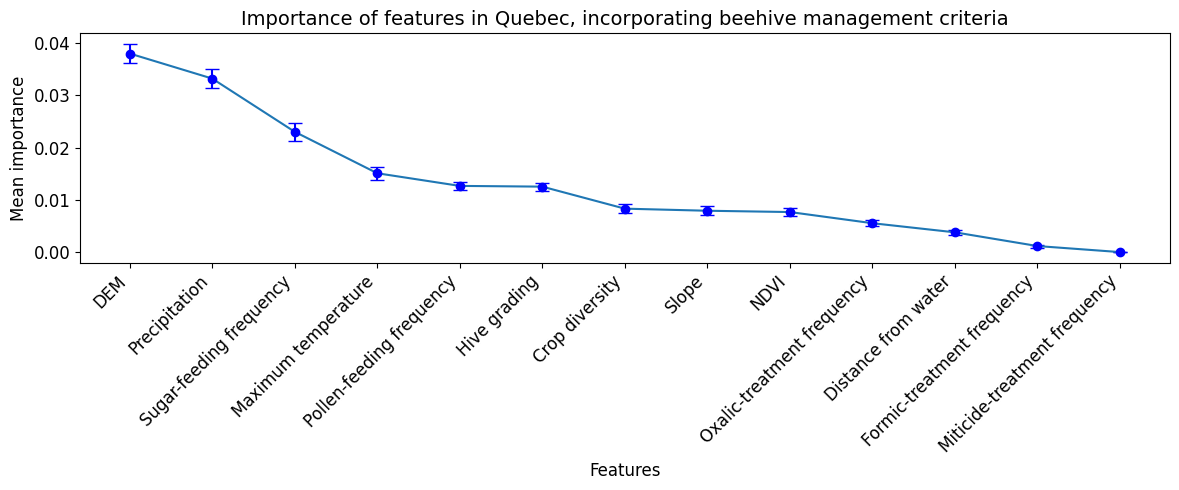

In [ ]:
# Applying the feature_importance_evaluation_RSF_model function
# The configuration including beehive management criteria
feature_importance_df_CA = feature_importance_evaluation_RSF_model(RSF_model = RSF_model_CA, X = X_CA, Y = Y_CA, dataframe = Dataframe_CA, study_area = 'California')
feature_importance_df_QC = feature_importance_evaluation_RSF_model(RSF_model = RSF_model_QC, X = X_QC, Y = Y_QC, dataframe = Dataframe_QC, study_area = 'Quebec')

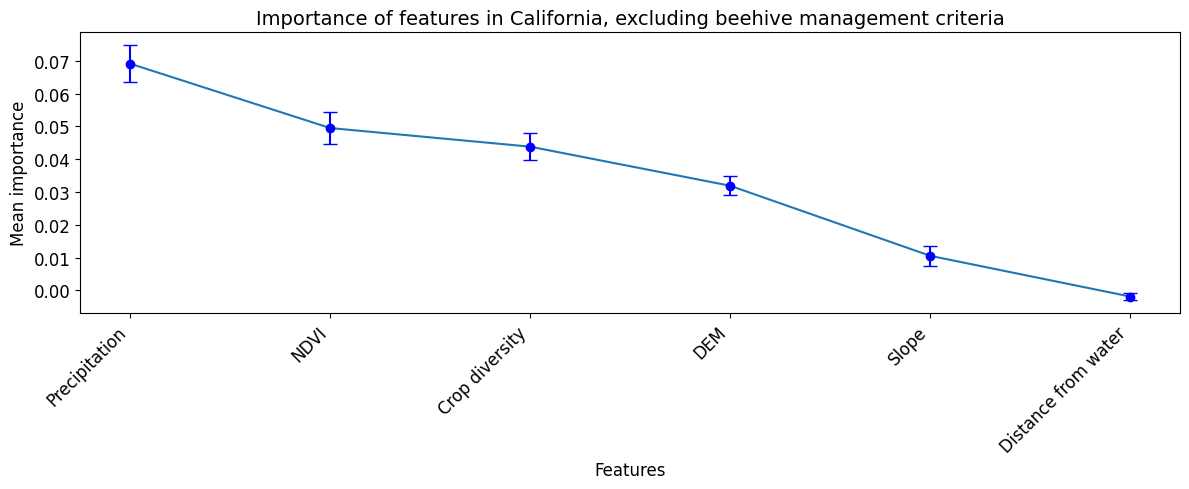

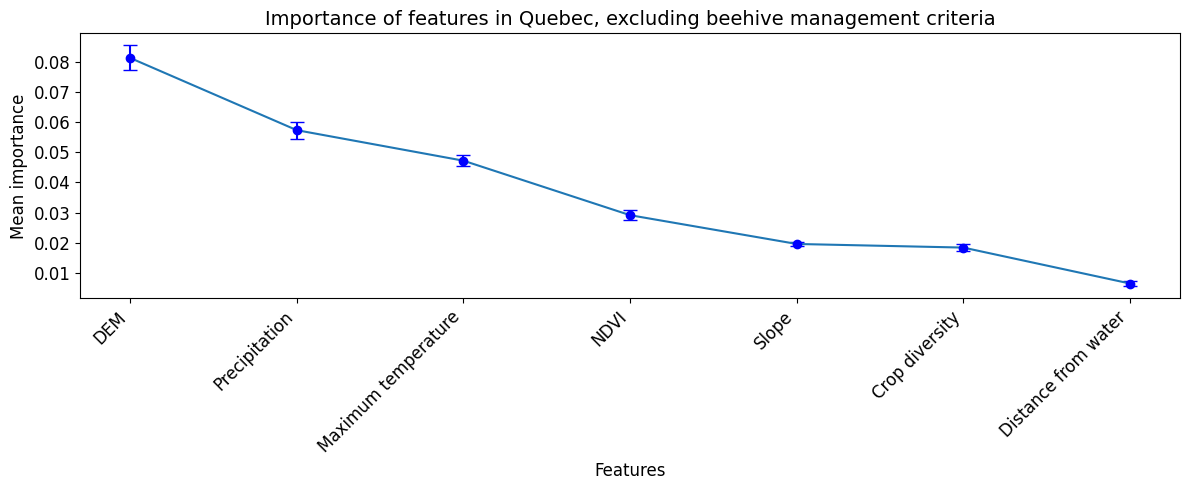

In [ ]:
# The configuration excluding beehive management criteria
feature_importance_df_CA_2 = feature_importance_evaluation_RSF_model(RSF_model = RSF_model_CA_2, X = X_CA_2, Y = Y_CA_2, dataframe = Dataframe_CA_2, study_area = 'California')
feature_importance_df_QC_2 = feature_importance_evaluation_RSF_model(RSF_model = RSF_model_QC_2, X = X_QC_2, Y = Y_QC_2, dataframe = Dataframe_QC_2, study_area = 'Quebec')

Plotting partial dependence to evaluate the importance of classes of the given variable/feature

In [ ]:
# Function to compute partial dependence
def compute_partial_dependence(model, X, variable, variable_values):
  survival_predictions = []
  event_times = model.predict_survival_function(X.iloc[[0]])[0].x
  for value in variable_values:
    X_temp = X.copy()
    X_temp[variable] = value
    surv_funcs = model.predict_survival_function(X_temp)
    mean_surv = np.mean([sf(event_times) for sf in surv_funcs], axis=0)
    survival_predictions.append(mean_surv)
  return np.array(survival_predictions), event_times

# Function to apply KBinsDiscretizer and print bin edges
def apply_kbins_discretizer(df, variable, n_quantiles=5):
  kbins = KBinsDiscretizer(n_bins=n_quantiles, encode='ordinal', strategy='quantile')
  df[variable] = kbins.fit_transform(df[[variable]]).astype(int)
  bin_edges = kbins.bin_edges_[0]
  print(f"Variable: {variable}")
  print(f"Bin edges: {bin_edges}")
  return df, bin_edges

# Function to plot partial dependence
def plotting_partial_dependence(df, state):
  if state == 'California':
    features_to_drop = ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months', 'Distance from roads',
                                            'Average temperature', 'Maximum temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']
  else:
    features_to_drop = ['Event', 'hive_identity_id', 'hive_age', 'Longitude', 'Latitude',  'Months','Distance from roads',
                                            'Average temperature', 'Minimum temperature',
                                            'Sugar-feeding frequency', 'Pollen-feeding frequency', 'Hive grading',
                                            'Oxalic-treatment frequency', 'Miticide-treatment frequency', 'Formic-treatment frequency', 'Movement', 'Relocation frequency']
  X = df.drop(columns=features_to_drop)
  Y = Surv.from_arrays(df['Event'], df['hive_age'])

  for variable_of_interest in X.columns:
    print(f'{variable_of_interest}')
    # Applying KBinsDiscretizer
    X, bin_edges = apply_kbins_discretizer(X, variable_of_interest)

    # Fitting a Random Survival Forest model
    if state == 'California':
      RSF_model = RandomSurvivalForest(random_state=0, n_estimators = 450, max_depth = 29, bootstrap=True)
    else:
      RSF_model = RandomSurvivalForest(random_state=0, n_estimators= 400, max_depth=13, bootstrap=True)

    RSF_model.fit(X, Y)

    # Getting unique quantile classes for partial dependence
    variable_values = np.unique(X[variable_of_interest])

    # Computing partial dependence
    partial_dependence, event_times = compute_partial_dependence(RSF_model, X, variable_of_interest, variable_values)

    # Creating a dictionary to map bin index to bin edge values
    bin_labels = {idx: f"[{bin_edges[idx]:.2f}, {bin_edges[idx+1]:.2f})" for idx in range(len(bin_edges)-1)}

    # Plotting partial dependence
    plt.figure(figsize=(10, 6))
    for j, (class_, pdp) in enumerate(zip(variable_values, partial_dependence)):
      plt.plot(event_times, pdp, label=f"{variable_of_interest}={bin_labels[class_]}", linewidth=2)
    plt.xlabel('Hive age (days)', fontsize=12)
    plt.ylabel('Survival Probability', fontsize=12)
    plt.title(f'Partial Dependence Plot for {variable_of_interest}', fontsize=14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()

Crop diversity
Variable: Crop diversity
Bin edges: [ 1.  9. 17. 23. 26. 32.]


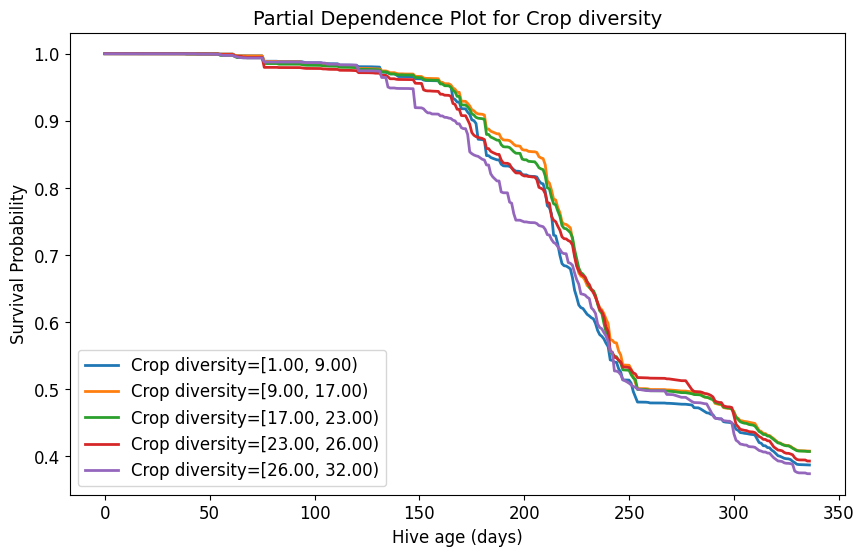

Distance from water
Variable: Distance from water
Bin edges: [    0.     5118.026 11444.25 ]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


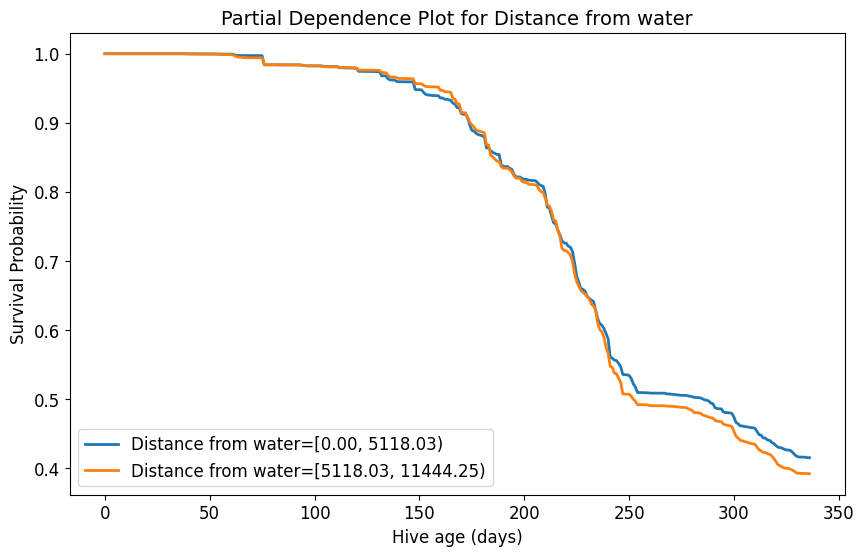

DEM
Variable: DEM
Bin edges: [  -2.876078    2.323052    8.677229   44.56973   168.7225   1516.072   ]


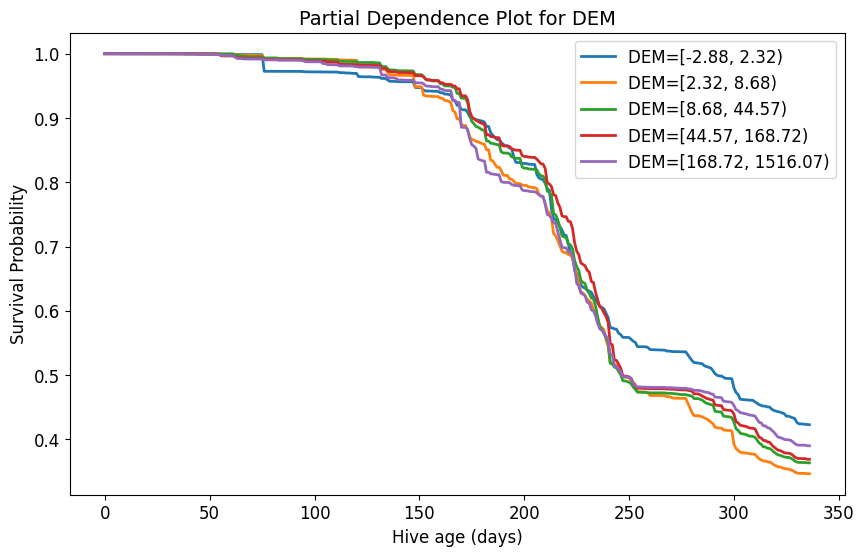

Slope
Variable: Slope
Bin edges: [ 0.912292  1.534338  1.827715  3.408147  7.490029 16.43635 ]


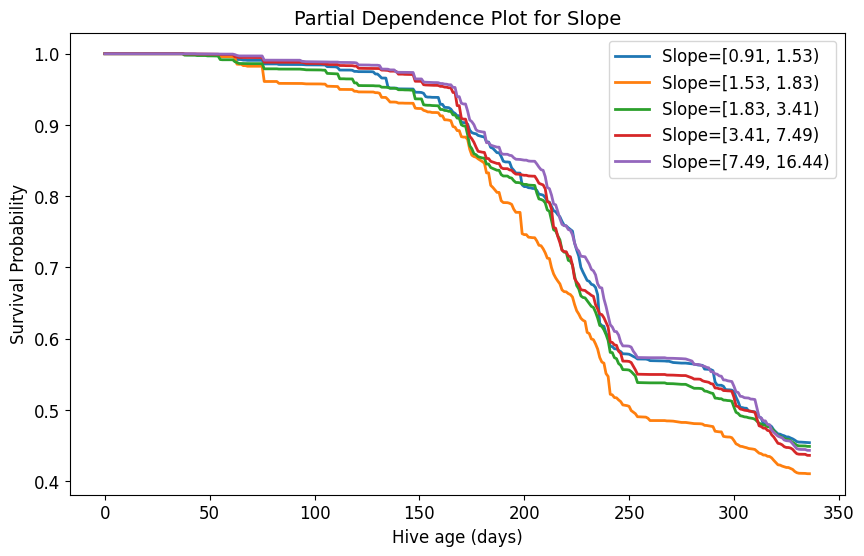

NDVI
Variable: NDVI
Bin edges: [0.026128 0.151606 0.177309 0.216245 0.262687 0.427234]


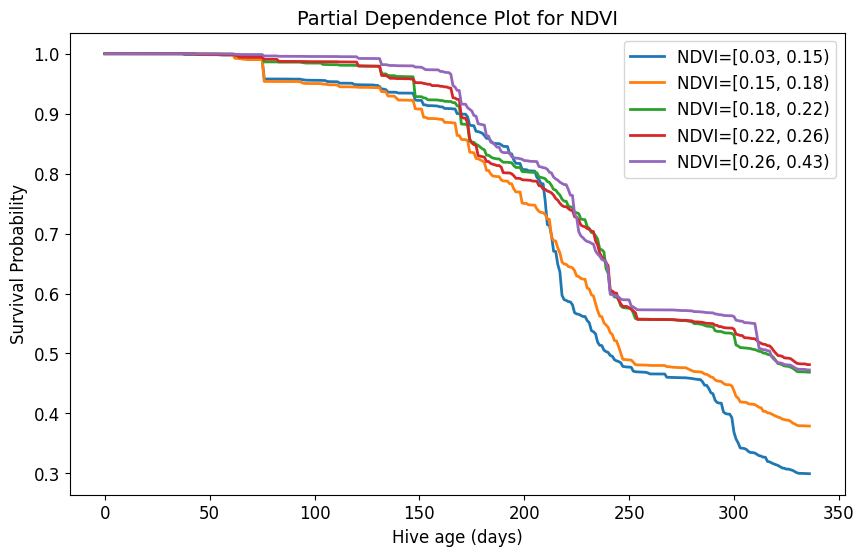

Precipitation
Variable: Precipitation
Bin edges: [0.000000e+00 9.966000e-03 2.780700e-01 5.597090e-01 2.495828e+00
 2.427452e+02]


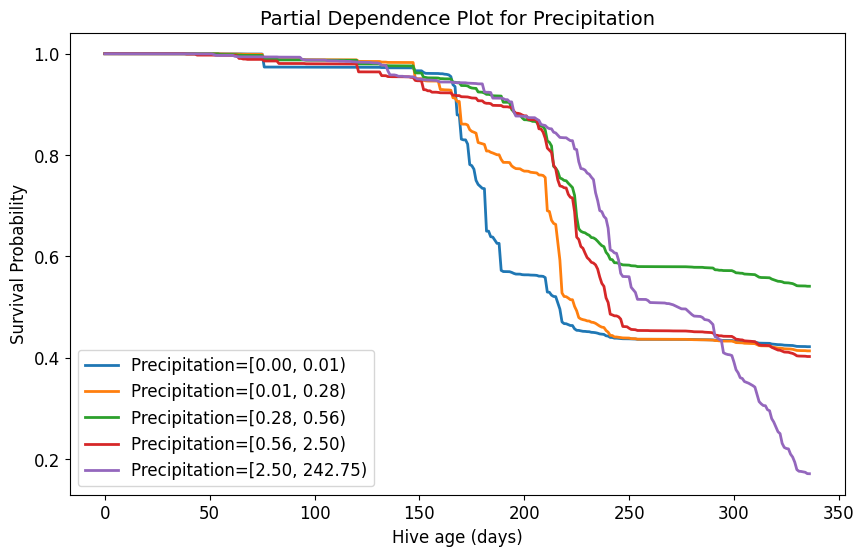

In [ ]:
# PDPs for California
plotting_partial_dependence(Processed_df_California, state='California')

Crop diversity
Variable: Crop diversity
Bin edges: [ 1.  3.  4.  5.  7. 10.]


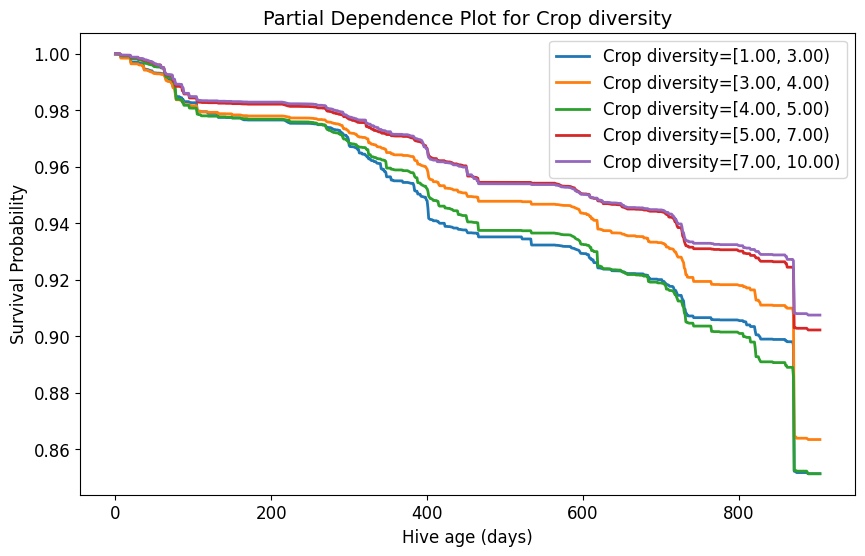

Distance from water
Variable: Distance from water
Bin edges: [    0.     6719.048 13438.1  ]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


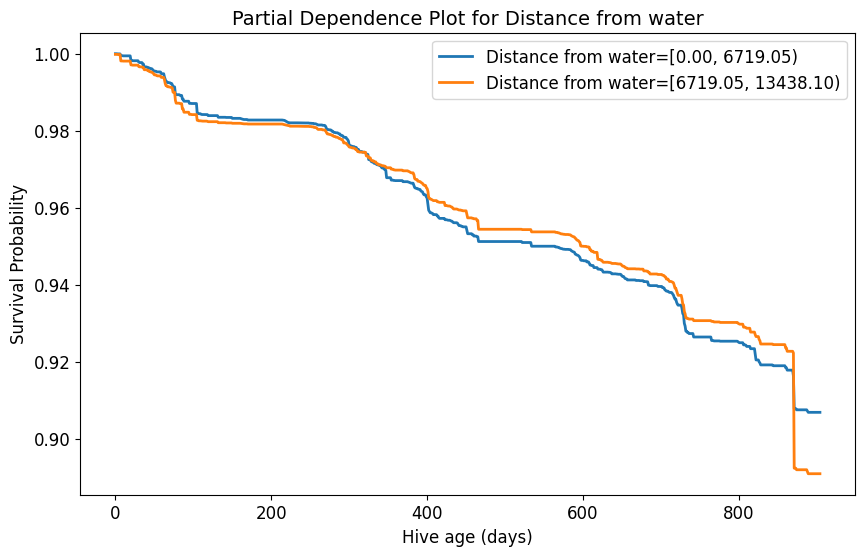

DEM
Variable: DEM
Bin edges: [  5.982838  53.32263   98.72694  133.1352   166.7646   321.6453  ]


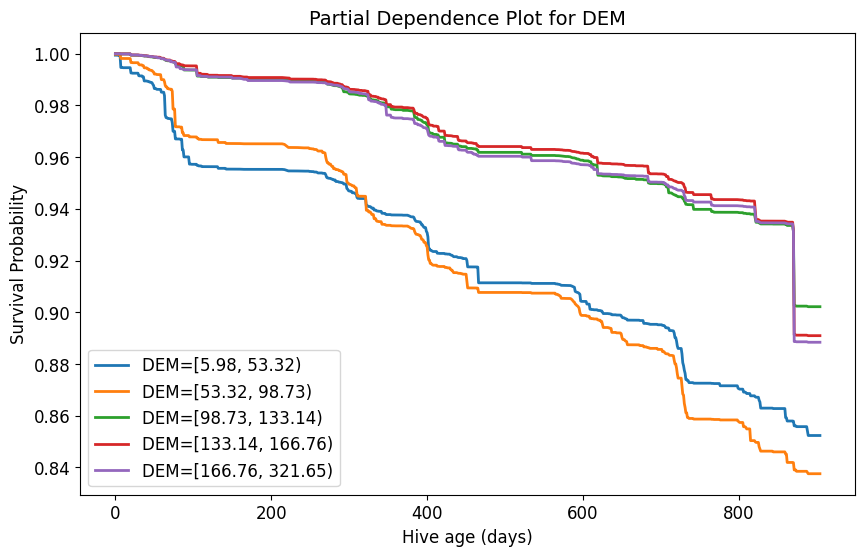

Slope
Variable: Slope
Bin edges: [1.010776 1.6491   2.085383 2.430376 3.521651 7.569828]


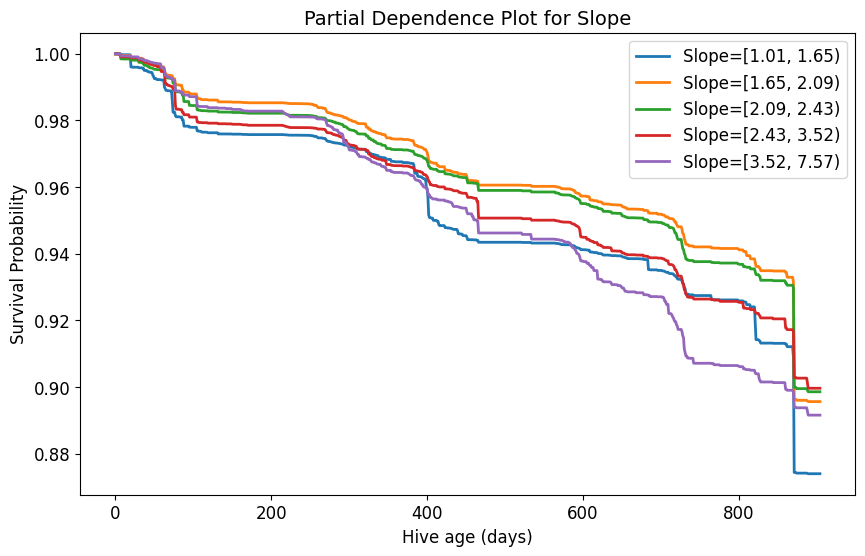

NDVI
Variable: NDVI
Bin edges: [0.       0.469084 0.590202 0.669503 0.745026 0.891766]


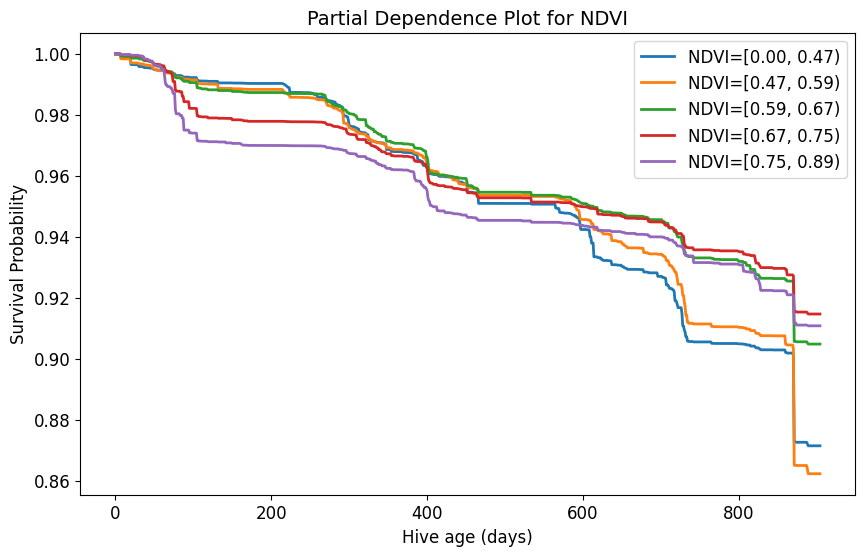

Maximum temperature
Variable: Maximum temperature
Bin edges: [19.84228 27.44291 30.03924 31.30298 32.41647 35.81856]


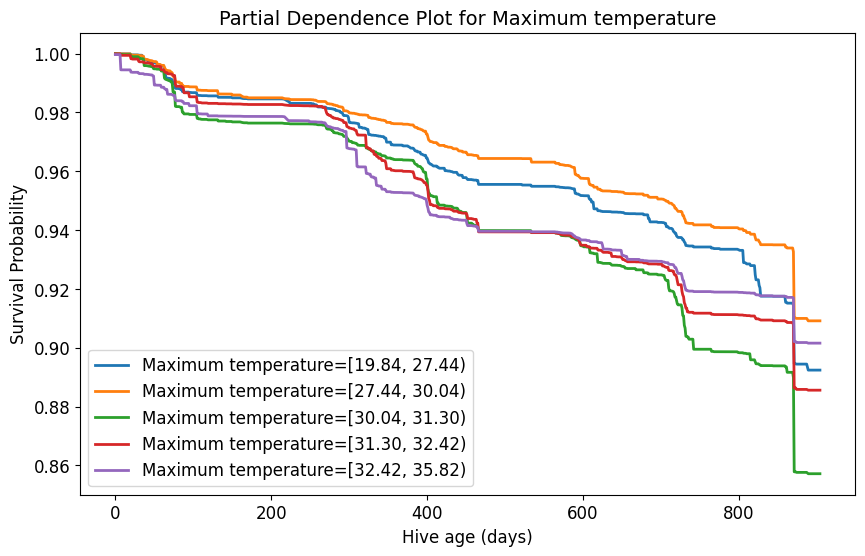

Precipitation
Variable: Precipitation
Bin edges: [  1.277172  43.02497   67.292     91.64495  116.7118   241.0419  ]


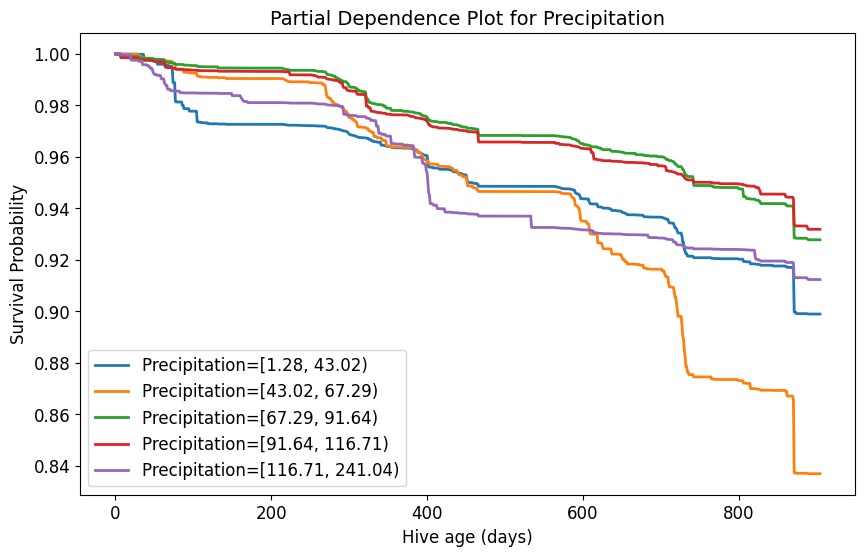

In [ ]:
# PDPs for Quebec
plotting_partial_dependence(Processed_df_Quebec, state='Quebec')

# Calculating the survival probability of each pixel in the study areas and providing beekeeping suitability maps

California

In [ ]:
# Defining raster file paths # Codes from this section on were run in Compute Canada
raster_paths = {
    'Precip': glob.glob('/home/navid94/Precip_CA/*.tif'),  # Glob to match all monthly Precip rasters
    'NDVI': glob.glob('/home/navid94/NDVI_CA/*.tif'),  # Glob to match all monthly NDVI rasters
    'DEM': '/home/navid94/CA/DEM_CA.tif',
    'Dis_water': '/home/navid94/CA/Dis_water_CA.tif',
    'LandC_Diversity': '/home/navid94/CA/LandC_Diversity_CA.tif',
    'Slope': '/home/navid94/CA/Slope_CA.tif'
}

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

# Read all rasters
Precip_data = [read_raster(fp)[0] for fp in raster_paths['Precip']]
NDVI_data = [read_raster(fp)[0] for fp in raster_paths['NDVI']]
DEM_data, transform_DEM = read_raster(raster_paths['DEM'])
Dis_water_data, transform_Dis_water = read_raster(raster_paths['Dis_water'])
LandC_Diversity_data, transform_LandC_Diversity = read_raster(raster_paths['LandC_Diversity'])
Slope_data, transform_Slope = read_raster(raster_paths['Slope'])

with rasterio.open(raster_paths['LandC_Diversity']) as src:
    LandC_Diversity_data_crs = src.crs

# Stack data into a single 3D array (time, rows, cols)
Precip_data_stack = np.stack(Precip_data, axis=0)
NDVI_data_stack = np.stack(NDVI_data, axis=0)

# The model needs a 1D array of features (n_samples, n_features)
n_months, rows, cols = Precip_data_stack.shape # Only one example of data is enough to get the number of rows and columns since all have got the same number of rows and columns


months = np.array([8,12,7,6,5,11,10,9])
month_name = ['Aug', 'Dec', 'Jul', 'Jun', 'May', 'Nov', 'Oct', 'Sep']

months_expanded = months[:, np.newaxis, np.newaxis]  # Shape (8, 1, 1)
months_expanded_array = months_expanded * np.ones((1, rows, cols))

# Replicate array1 along the first dimension to match the shape of array2
DEM_expanded_array = np.tile(DEM_data, (len(months), 1, 1))
Dis_water_expanded_array = np.tile(Dis_water_data, (len(months), 1, 1))
LandC_Diversity_expanded_array = np.tile(LandC_Diversity_data, (len(months), 1, 1))
Slope_expanded_array = np.tile(Slope_data, (len(months), 1, 1))


# Compute survival probabilities for each month
for m in range(n_months):
    print('Month: ', month_name[m])

    mean_survival_probs = np.zeros((rows, cols)).reshape(-1,1)

    months_expanded_array_flat = months_expanded_array[m].reshape(-1,1)
    LandC_Diversity_expanded_array_flat = LandC_Diversity_expanded_array[m].reshape(-1,1)
    Dis_water_expanded_array_flat= Dis_water_expanded_array[m].reshape(-1,1)
    DEM_expanded_array_flat = DEM_expanded_array[m].reshape(-1,1)
    Slope_expanded_array_flat = Slope_expanded_array[m].reshape(-1,1)
    NDVI_data_stack_flat = NDVI_data_stack[m].reshape(-1,1)
    Precip_data_stack_flat = Precip_data_stack[m].reshape(-1,1)

    feature_vector = np.hstack((months_expanded_array_flat, LandC_Diversity_expanded_array_flat, Dis_water_expanded_array_flat, DEM_expanded_array_flat, Slope_expanded_array_flat, NDVI_data_stack_flat, Precip_data_stack_flat))

    print('Number of pixels: ', len(feature_vector))

    for cell_index in range(len(feature_vector)):
        print('Pixel: ', cell_index + 1)

        if np.isnan(feature_vector[cell_index]).any():
            mean_survival_probs[cell_index] = np.nan
        else:
            # Predict survival probabilities
            mean_survival_probs[cell_index] = np.mean(RSF_model_CA_2.predict_survival_function(feature_vector[cell_index].reshape(1,-1))[0].y)

    survival_prob_array = np.array(mean_survival_probs).reshape(rows, cols)

    np.save('/home/navid94/CA_mean_survival_probability_' + month_name[m] + '.npy', survival_prob_array)
    output_raster = '/home/navid94/CA_mean_survival_probability_' + month_name[m] + '.tif'

    with rasterio.open(
        output_raster,
        'w',
        driver='GTiff',
        height=rows,
        width=cols,
        count=1,
        dtype=survival_prob_array.dtype,
        crs=LandC_Diversity_data_crs,
        transform=transform_LandC_Diversity,
    ) as dst:
        dst.write(survival_prob_array, 1)


print("Processing complete. The mean survival probability raster has been saved.")

Quebec

In [ ]:
# Defining raster paths
raster_paths = {
    'Air_max': glob.glob('/home/navid94/Air_max_QC/*.tif'),  # Glob to match all monthly Air_max rasters
    'Precip': glob.glob('/home/navid94/Precip_QC/*.tif'),  # Glob to match all monthly Precip rasters
    'NDVI': glob.glob('/home/navid94/NDVI_QC/*.tif'),  # Glob to match all monthly NDVI rasters
    'DEM': '/home/navid94/QC/DEM_QC.tif',
    'Dis_water': '/home/navid94/QC/Dis_water_QC.tif',
    'LandC_Diversity': '/home/navid94/QC/LandC_Diversity_QC.tif',
    'Slope': '/home/navid94/QC/Slope_QC.tif'
}

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

# Read all rasters
Air_max_data = [read_raster(fp)[0] for fp in raster_paths['Air_max']]
Precip_data = [read_raster(fp)[0] for fp in raster_paths['Precip']]
NDVI_data = [read_raster(fp)[0] for fp in raster_paths['NDVI']]
DEM_data, transform_DEM = read_raster(raster_paths['DEM'])
Dis_water_data, transform_Dis_water = read_raster(raster_paths['Dis_water'])
LandC_Diversity_data, transform_LandC_Diversity = read_raster(raster_paths['LandC_Diversity'])
Slope_data, transform_Slope = read_raster(raster_paths['Slope'])

with rasterio.open(raster_paths['LandC_Diversity']) as src:
    LandC_Diversity_data_crs = src.crs

# Stack data into a single 3D array (time, rows, cols)
Air_max_data_stack = np.stack(Air_max_data, axis=0)
Precip_data_stack = np.stack(Precip_data, axis=0)
NDVI_data_stack = np.stack(NDVI_data, axis=0)

# The model needs a 1D array of features (n_samples, n_features)
n_months, rows, cols = Air_max_data_stack.shape # Only one example of data is enough to get the number of rows and columns since all have got the same number of rows and columns


months = np.array([4,8,7,6,5,10,9])
month_name = ['Apr', 'Aug', 'Jul', 'Jun', 'May', 'Oct', 'Sep']

months_expanded = months[:, np.newaxis, np.newaxis]  # Shape (7, 1, 1)
months_expanded_array = months_expanded * np.ones((1, rows, cols))

# Replicate array1 along the first dimension to match the shape of array2
DEM_expanded_array = np.tile(DEM_data, (len(months), 1, 1))
Dis_water_expanded_array = np.tile(Dis_water_data, (len(months), 1, 1))
LandC_Diversity_expanded_array = np.tile(LandC_Diversity_data, (len(months), 1, 1))
Slope_expanded_array = np.tile(Slope_data, (len(months), 1, 1))


# Compute survival probabilities for each month
for m in range(n_months):
    print('Month: ', month_name[m])

    mean_survival_probs = np.zeros((rows, cols)).reshape(-1,1)

    months_expanded_array_flat = months_expanded_array[m].reshape(-1,1)
    LandC_Diversity_expanded_array_flat = LandC_Diversity_expanded_array[m].reshape(-1,1)
    Dis_water_expanded_array_flat= Dis_water_expanded_array[m].reshape(-1,1)
    DEM_expanded_array_flat = DEM_expanded_array[m].reshape(-1,1)
    Slope_expanded_array_flat = Slope_expanded_array[m].reshape(-1,1)
    NDVI_data_stack_flat = NDVI_data_stack[m].reshape(-1,1)
    Air_max_data_stack_flat = Air_max_data_stack[m].reshape(-1,1)
    Precip_data_stack_flat = Precip_data_stack[m].reshape(-1,1)

    feature_vector = np.hstack((months_expanded_array_flat, LandC_Diversity_expanded_array_flat, Dis_water_expanded_array_flat, DEM_expanded_array_flat, Slope_expanded_array_flat, NDVI_data_stack_flat, Air_max_data_stack_flat, Precip_data_stack_flat))

    print('Number of pixels: ', len(feature_vector))

    for cell_index in range(len(feature_vector)):
        print('Pixel: ', cell_index + 1)

        if np.isnan(feature_vector[cell_index]).any():
            mean_survival_probs[cell_index] = np.nan
        else:
            # Predict survival probabilities
            mean_survival_probs[cell_index] = np.mean(RSF_model_QC_2.predict_survival_function(feature_vector[cell_index].reshape(1,-1))[0].y)

    survival_prob_array = np.array(mean_survival_probs).reshape(rows, cols)

    np.save('/home/navid94/QC_mean_survival_probability_' + month_name[m] + '.npy', survival_prob_array)
    output_raster = '/home/navid94/QC_mean_survival_probability_' + month_name[m] + '.tif'

    with rasterio.open(
        output_raster,
        'w',
        driver='GTiff',
        height=rows,
        width=cols,
        count=1,
        dtype=survival_prob_array.dtype,
        crs=LandC_Diversity_data_crs,
        transform=transform_LandC_Diversity,
    ) as dst:
        dst.write(survival_prob_array, 1)


print("Processing complete. The mean survival probability raster has been saved.")


